<a href="https://colab.research.google.com/github/UjwalNagrikar/Algo-Trading--Models-crypto/blob/main/Quant_Trading_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🚀 ADVANCED TRADING STRATEGY BACKTESTER
   McGinley Dynamic + RSI + MACD + Bollinger Bands

📥 Downloading BTC-USD data...
   Interval: 20m, Period: 1d


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (period=1d) (Yahoo error = "Invalid input - interval=20m is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 4h, 1d, 5d, 1wk, 1mo, 3mo]")')


⚠️  No data downloaded. Using synthetic data.
🔧 Generating 5000 bars of synthetic data...
✓ Generated 5000 bars


🚀 STARTING ADVANCED BACKTEST
Initial Capital: ₹500,000.00
Risk per Trade: 9%
Data Period: 2024-01-01 00:00:00 to 2024-07-27 07:00:00
Total Bars: 5000

📊 Calculating indicators...
✓ Indicators calculated

🔄 Running backtest...


🔔 LONG Entry @ ₹50374.98
  Quantity: 7.4442 | Value: ₹375,000
  Stop Loss: ₹45337.48 (10%) | Take Profit: ₹56419.98 (12%)
✅ Time Stop: LONG | ₹51732.76 | P&L: ₹10,108 (2.7%)

🔔 SHORT Entry @ ₹52061.36
  Quantity: 7.3486 | Value: ₹382,581
  Stop Loss: ₹57267.50 (10%) | Take Profit: ₹45814.00 (12%)
❌ Stop Loss: SHORT | ₹57750.49 | P&L: ₹-41,807 (-10.9%)

🔔 LONG Entry @ ₹58155.34
  Quantity: 7.1178 | Value: ₹413,936
  Stop Loss: ₹52339.81 (10%) | Take Profit: ₹65133.98 (12%)
  ✓ Partial exit (50%) at 6.2% profit
  → Trailing stop activated at 8.2% profit
✅ Take Profit: LONG | ₹65220.36 | P&L: ₹25,144 (6.1%)

🔔 LONG Entry @ ₹65220.36
  Quantity: 6.7841 |

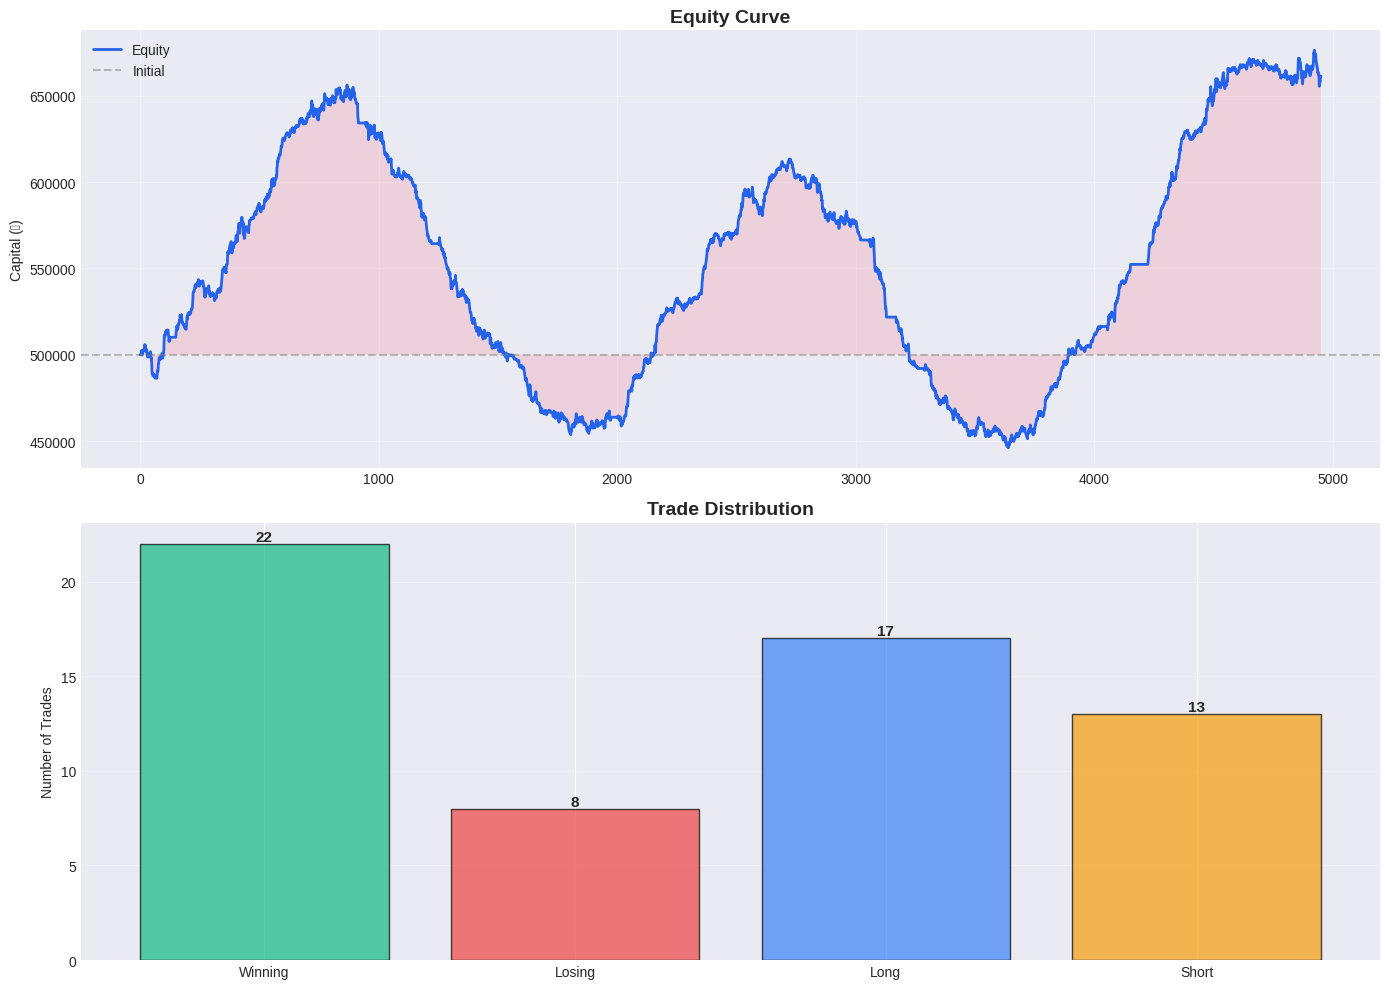

✅ BACKTEST COMPLETE!



In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class AdvancedTradingStrategy:
    def __init__(self, initial_capital=500000, risk_per_trade = 0.09 ):
        """
        Enhanced trading strategy with improved accuracy

        Args:
            initial_capital: Starting capital in INR
            risk_per_trade: Risk percentage per trade (default 10%)
        """
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

    def calculate_mcginley_dynamic(self, prices, period=14, constant=0.6):
        """Calculate McGinley Dynamic - adaptive moving average"""
        md = pd.Series(index=prices.index, dtype=float)
        md.iloc[0] = prices.iloc[0]

        for i in range(1, len(prices)):
            prev_md = md.iloc[i-1]
            price = prices.iloc[i]

            if prev_md == 0 or pd.isna(prev_md):
                md.iloc[i] = price
                continue

            ratio = max(0.5, min(price / prev_md, 2.0))
            n = max(period * (ratio ** 4) * constant, 1.0)
            md.iloc[i] = prev_md + (price - prev_md) / n

        return md

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI with Wilder's smoothing"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    def calculate_atr(self, high, low, close, period=14):
        """Calculate Average True Range"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.ewm(span=period, adjust=False).mean()
        return atr

    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band

    def calculate_trend_strength(self, close, md, period=20):
        """Calculate trend strength (0-1 scale)"""
        price_above_md = (close > md).astype(int)
        trend_strength = price_above_md.rolling(window=period).mean()
        return trend_strength

    def calculate_volume_profile(self, volume, period=20):
        """Calculate volume trend"""
        vol_ma = volume.rolling(window=period).mean()
        vol_ratio = volume / vol_ma
        return vol_ratio

    def calculate_momentum(self, prices, period=10):
        """Calculate price momentum"""
        momentum = prices.diff(period) / prices.shift(period) * 100
        return momentum

    def is_liquid_hour(self, timestamp):
        """Check if trading during high liquidity hours"""
        hour = timestamp.hour
        return 0 <= hour <= 10  # Extended for crypto markets

    def check_long_signal(self, i, close, md, rsi, macd_hist, macd_line,
                         trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced long entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses above McGinley Dynamic OR price above MD with momentum
        2. RSI > 45 (bullish territory)
        3. MACD bullish (crossover OR already positive with upward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_above_md = close.iloc[i] > md.iloc[i]
        price_cross = (close.iloc[i-1] <= md.iloc[i-1] and
                      close.iloc[i] > md.iloc[i])
        # Accept if crossing OR already above with momentum
        price_signal = price_cross or (price_above_md and close.iloc[i] > close.iloc[i-1])

        # Core Signal 2: RSI in bullish zone (relaxed from 50-75 to 45-80)
        rsi_valid = 45 < rsi.iloc[i] < 80

        # Core Signal 3: MACD bullish (crossover OR positive with momentum)
        macd_cross = (macd_hist.iloc[i] > 0 and macd_hist.iloc[i-1] <= 0)
        macd_positive = macd_hist.iloc[i] > 0 and macd_line.iloc[i] > macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_positive

        # Confirmation 1: Not in extreme overbought (relaxed)
        not_extreme = rsi.iloc[i] < 78

        # Confirmation 2: Some positive momentum
        has_momentum = close.iloc[i] > close.iloc[i-2] or momentum.iloc[i] > -1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] > 0.3 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def check_short_signal(self, i, close, md, rsi, macd_hist, macd_line,
                          trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced short entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses below McGinley Dynamic OR price below MD with momentum
        2. RSI < 55 (bearish territory)
        3. MACD bearish (crossover OR already negative with downward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_below_md = close.iloc[i] < md.iloc[i]
        price_cross = (close.iloc[i-1] >= md.iloc[i-1] and
                      close.iloc[i] < md.iloc[i])
        # Accept if crossing OR already below with momentum
        price_signal = price_cross or (price_below_md and close.iloc[i] < close.iloc[i-1])

        # Core Signal 2: RSI in bearish zone (relaxed from 25-50 to 20-55)
        rsi_valid = 20 < rsi.iloc[i] < 55

        # Core Signal 3: MACD bearish (crossover OR negative with momentum)
        macd_cross = (macd_hist.iloc[i] < 0 and macd_hist.iloc[i-1] >= 0)
        macd_negative = macd_hist.iloc[i] < 0 and macd_line.iloc[i] < macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_negative

        # Confirmation 1: Not in extreme oversold (relaxed)
        not_extreme = rsi.iloc[i] > 22

        # Confirmation 2: Some negative momentum
        has_momentum = close.iloc[i] < close.iloc[i-2] or momentum.iloc[i] < 1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] < 0.7 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def calculate_position_size(self, price, atr, volatility_pct=None):
        """
        Dynamic position sizing based on volatility and risk management

        Args:
            price: Current price
            atr: Average True Range
            volatility_pct: Volatility percentile (0-1)
        """
        # Base risk amount
        risk_amount = self.capital * self.risk_per_trade

        # Calculate base position size (10% stop loss)
        stop_loss_pct = 0.10
        position_size = risk_amount / (price * stop_loss_pct)

        # Adjust for ATR-based volatility
        if not np.isnan(atr):
            atr_pct = (atr / price) * 100

            if atr_pct > 3.5:  # Very high volatility
                position_size *= 0.5
            elif atr_pct > 2.5:  # High volatility
                position_size *= 0.65
            elif atr_pct > 1.5:  # Medium volatility
                position_size *= 0.8
            # Low volatility: keep full size

        # Maximum 75% of capital (conservative)
        max_position = (self.capital * 0.75) / price
        position_size = min(position_size, max_position)

        # Minimum 5% of capital
        min_position = (self.capital * 0.05) / price
        position_size = max(position_size, min_position)

        return position_size

    def calculate_dynamic_stops(self, entry_price, atr, position_type):
        """Calculate fixed stop loss and take profit"""
        # Fixed 12% take profit
        tp_pct = 0.12

        # Stop loss between 10-12% based on volatility
        if pd.isna(atr):
            sl_pct = 0.10
        else:
            atr_distance = atr / entry_price
            # If high volatility, use wider stop (up to 12%)
            if atr_distance > 0.03:
                sl_pct = 0.12
            elif atr_distance > 0.02:
                sl_pct = 0.11
            else:
                sl_pct = 0.10

        if position_type == 'LONG':
            stop_loss = entry_price * (1 - sl_pct)
            take_profit = entry_price * (1 + tp_pct)
        else:
            stop_loss = entry_price * (1 + sl_pct)
            take_profit = entry_price * (1 - tp_pct)

        return stop_loss, take_profit, sl_pct, tp_pct

    def check_exit_conditions(self, i, close, md, rsi):
        """
        Enhanced exit logic with trailing stop
        """
        current_price = close.iloc[i]
        entry_price = self.position['entry']

        # Calculate P&L
        if self.position['type'] == 'LONG':
            pnl_pct = (current_price - entry_price) / entry_price
        else:
            pnl_pct = (entry_price - current_price) / entry_price

        # Activate trailing stop at 8% profit
        if pnl_pct > 0.08 and not self.position.get('trailing_active'):
            self.position['trailing_active'] = True
            self.position['highest_price'] = current_price
            print(f"  → Trailing stop activated at {pnl_pct*100:.1f}% profit")

        # Update trailing stop
        if self.position.get('trailing_active'):
            if self.position['type'] == 'LONG':
                if current_price > self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    # Lock in 50% of profit
                    self.position['trailing_stop'] = (
                        entry_price + (current_price - entry_price) * 0.5
                    )
            else:
                if current_price < self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = (
                        entry_price - (entry_price - current_price) * 0.5
                    )

        # Partial exit at 6% profit
        if not self.position.get('partial_exited') and pnl_pct >= 0.06:
            exit_qty = self.position['quantity'] * 0.5
            exit_value = exit_qty * current_price
            self.capital += exit_value
            self.position['quantity'] -= exit_qty
            self.position['partial_exited'] = True

            # Move stop to breakeven
            self.position['stop_loss'] = entry_price

            print(f"  ✓ Partial exit (50%) at {pnl_pct*100:.1f}% profit")

        # Check exit conditions
        exit_reason = None

        # 1. Trailing stop
        if self.position.get('trailing_active'):
            ts = self.position.get('trailing_stop', 0)
            if ((self.position['type'] == 'LONG' and current_price < ts) or
                (self.position['type'] == 'SHORT' and current_price > ts)):
                exit_reason = 'Trailing Stop'

        # 2. Stop loss and take profit
        if not exit_reason:
            sl_pct = self.position.get('sl_pct', 0.10)
            tp_pct = self.position.get('tp_pct', 0.15)

            if pnl_pct >= tp_pct:
                exit_reason = 'Take Profit'
            elif pnl_pct <= -sl_pct:
                exit_reason = 'Stop Loss'

        # 3. Time-based exit (prevent dead trades)
        bars_held = i - self.position.get('entry_bar', i)
        if bars_held > 120 and abs(pnl_pct) < 0.03:
            exit_reason = 'Time Stop'

        # 4. Signal reversal (strong opposite signal)
        if not exit_reason:
            if self.position['type'] == 'LONG':
                if close.iloc[i] < md.iloc[i] * 0.97 and rsi.iloc[i] < 40:
                    exit_reason = 'Signal Reversal'
            else:
                if close.iloc[i] > md.iloc[i] * 1.03 and rsi.iloc[i] > 60:
                    exit_reason = 'Signal Reversal'

        return exit_reason

    def execute_exit(self, i, close, timestamp, exit_reason):
        """Execute exit with P&L calculation"""
        current_price = close.iloc[i]
        exit_value = self.position['quantity'] * current_price
        self.capital += exit_value

        # Calculate P&L
        original_qty = self.position.get('original_quantity', self.position['quantity'])
        if self.position['type'] == 'LONG':
            pnl = exit_value - (self.position['quantity'] * self.position['entry'])
        else:
            pnl = (self.position['quantity'] * self.position['entry']) - exit_value

        pnl_pct = (pnl / (original_qty * self.position['entry'])) * 100

        # Record trade
        trade = {
            'type': self.position['type'],
            'entry': self.position['entry'],
            'entry_time': self.position['entry_time'],
            'exit': current_price,
            'exit_time': timestamp,
            'quantity': self.position['quantity'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'bars_held': i - self.position.get('entry_bar', i)
        }

        self.trades.append(trade)

        emoji = "✅" if pnl > 0 else "❌"
        print(f"{emoji} {exit_reason}: {self.position['type']} | "
              f"₹{current_price:.2f} | P&L: ₹{pnl:,.0f} ({pnl_pct:.1f}%)")

        self.position = None

    def execute_entry(self, i, close, timestamp, signal_type, position_size, atr):
        """Execute entry trade"""
        entry_price = close.iloc[i]
        position_value = position_size * entry_price

        if position_value <= self.capital * 0.95:
            sl, tp, sl_pct, tp_pct = self.calculate_dynamic_stops(
                entry_price, atr, signal_type
            )

            self.position = {
                'type': signal_type,
                'entry': entry_price,
                'entry_time': timestamp,
                'entry_bar': i,
                'quantity': position_size,
                'original_quantity': position_size,
                'partial_exited': False,
                'trailing_active': False,
                'stop_loss': sl,
                'take_profit': tp,
                'sl_pct': sl_pct,
                'tp_pct': tp_pct
            }

            self.capital -= position_value

            print(f"\n🔔 {signal_type} Entry @ ₹{entry_price:.2f}")
            print(f"  Quantity: {position_size:.4f} | Value: ₹{position_value:,.0f}")
            print(f"  Stop Loss: ₹{sl:.2f} ({sl_pct*100:.0f}%) | Take Profit: ₹{tp:.2f} (12%)")

    def backtest(self, data):
        """Run complete backtest"""
        print(f"\n{'='*80}")
        print(f"🚀 STARTING ADVANCED BACKTEST")
        print(f"{'='*80}")
        print(f"Initial Capital: ₹{self.initial_capital:,.2f}")
        print(f"Risk per Trade: {self.risk_per_trade*100:.0f}%")
        print(f"Data Period: {data.index[0]} to {data.index[-1]}")
        print(f"Total Bars: {len(data)}")
        print(f"{'='*80}\n")

        # Calculate all indicators
        close = data['Close']
        high = data['High']
        low = data['Low']
        volume = data['Volume']

        print("📊 Calculating indicators...")
        md = self.calculate_mcginley_dynamic(close)
        rsi = self.calculate_rsi(close)
        macd_line, signal_line, macd_hist = self.calculate_macd(close)
        atr = self.calculate_atr(high, low, close)
        bb_upper, bb_mid, bb_lower = self.calculate_bollinger_bands(close)
        trend_strength = self.calculate_trend_strength(close, md)
        momentum = self.calculate_momentum(close)

        # Add to dataframe
        data['MD'] = md
        data['RSI'] = rsi
        data['MACD_Line'] = macd_line
        data['MACD_Signal'] = signal_line
        data['MACD_Hist'] = macd_hist
        data['ATR'] = atr
        data['BB_Upper'] = bb_upper
        data['BB_Lower'] = bb_lower
        data['Trend_Strength'] = trend_strength
        data['Momentum'] = momentum

        print("✓ Indicators calculated\n")
        print("🔄 Running backtest...\n")

        # Backtest loop
        for i in range(50, len(data)):
            timestamp = data.index[i]

            # Time filter
            if not self.is_liquid_hour(timestamp):
                equity = self.capital + (
                    self.position['quantity'] * close.iloc[i]
                    if self.position else 0
                )
                self.equity_curve.append(equity)
                continue

            # Exit management
            if self.position:
                exit_reason = self.check_exit_conditions(i, close, md, rsi)
                if exit_reason:
                    self.execute_exit(i, close, timestamp, exit_reason)

            # Entry signals
            if not self.position:
                position_size = self.calculate_position_size(
                    close.iloc[i], atr.iloc[i]
                )

                # Check long
                if self.check_long_signal(i, close, md, rsi, macd_hist,
                                         macd_line, trend_strength,
                                         bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'LONG',
                                     position_size, atr.iloc[i])

                # Check short
                elif self.check_short_signal(i, close, md, rsi, macd_hist,
                                            macd_line, trend_strength,
                                            bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'SHORT',
                                     position_size, atr.iloc[i])

            # Record equity
            equity = self.capital + (
                self.position['quantity'] * close.iloc[i]
                if self.position else 0
            )
            self.equity_curve.append(equity)

        # Close final position
        if self.position:
            self.execute_exit(len(data)-1, close, data.index[-1], 'End of Backtest')

        print(f"\n{'='*80}")
        print("✓ Backtest completed")
        print(f"{'='*80}\n")

        return self.generate_results()

    def generate_results(self):
        """Generate comprehensive statistics"""
        if not self.trades:
            print("⚠️  No trades executed")
            return None

        trades_df = pd.DataFrame(self.trades)

        # Performance metrics
        total_return = ((self.capital - self.initial_capital) /
                       self.initial_capital) * 100

        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]

        win_rate = len(winning_trades) / len(trades_df) * 100
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['pnl'].mean()) if len(losing_trades) > 0 else 0
        profit_factor = avg_win / avg_loss if avg_loss > 0 else 0

        # Risk metrics
        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min())

        # Sharpe ratio (annualized for hourly data)
        returns = equity_series.pct_change().dropna()
        sharpe = ((returns.mean() / returns.std()) * np.sqrt(252 * 24)
                 if returns.std() > 0 else 0)

        # Additional metrics
        total_long = len(trades_df[trades_df['type'] == 'LONG'])
        total_short = len(trades_df[trades_df['type'] == 'SHORT'])
        avg_bars = trades_df['bars_held'].mean()

        # Consecutive wins/losses
        win_streak = 0
        loss_streak = 0
        current_streak = 0
        for pnl in trades_df['pnl']:
            if pnl > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
                win_streak = max(win_streak, current_streak)
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
                loss_streak = max(loss_streak, abs(current_streak))

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': len(trades_df),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'total_long': total_long,
            'total_short': total_short,
            'avg_bars_held': avg_bars,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve
        }

    def print_results(self, results):
        """Print formatted results"""
        if not results:
            return

        print(f"{'='*80}")
        print("📈 BACKTEST RESULTS")
        print(f"{'='*80}\n")

        print("💰 CAPITAL PERFORMANCE")
        print(f"  Initial Capital:     ₹{results['initial_capital']:>12,.0f}")
        print(f"  Final Capital:       ₹{results['final_capital']:>12,.0f}")
        print(f"  Total Return:        {results['total_return']:>12.2f}%")
        print(f"  Max Drawdown:        {results['max_drawdown']:>12.2f}%")
        print(f"  Sharpe Ratio:        {results['sharpe_ratio']:>12.2f}")

        print(f"\n📊 TRADE STATISTICS")
        print(f"  Total Trades:        {results['total_trades']:>12}")
        print(f"  Long Trades:         {results['total_long']:>12}")
        print(f"  Short Trades:        {results['total_short']:>12}")
        print(f"  Winning Trades:      {results['winning_trades']:>12}")
        print(f"  Losing Trades:       {results['losing_trades']:>12}")
        print(f"  Win Rate:            {results['win_rate']:>12.1f}%")
        print(f"  Avg Bars Held:       {results['avg_bars_held']:>12.1f}")

        print(f"\n💵 PROFITABILITY")
        print(f"  Average Win:         ₹{results['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹{results['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:       {results['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:      {results['max_win_streak']:>12}")
        print(f"  Max Loss Streak:     {results['max_loss_streak']:>12}")

        print(f"\n{'='*80}")
        print("📋 LAST 10 TRADES")
        print(f"{'='*80}\n")

        for idx, trade in results['trades_df'].tail(10).iterrows():
            emoji = "✅" if trade['pnl'] > 0 else "❌"
            print(f"{emoji} {trade['type']:5} | Entry: ₹{trade['entry']:8.2f} | "
                  f"Exit: ₹{trade['exit']:8.2f} | P&L: {trade['pnl_pct']:6.1f}% | "
                  f"{trade['exit_reason']}")

        print(f"\n{'='*80}\n")

    def plot_results(self, results, data):
        """Plot backtest results"""
        if not results:
            return

        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        # Equity Curve
        equity = results['equity_curve']
        axes[0].plot(equity, linewidth=2, color='#2563eb', label='Equity')
        axes[0].axhline(self.initial_capital, color='gray', linestyle='--', alpha=0.5, label='Initial')
        axes[0].fill_between(range(len(equity)), equity, self.initial_capital, alpha=0.2)
        axes[0].set_title('Equity Curve', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Capital (₹)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Trade Distribution
        trades_df = results['trades_df']
        winning = len(trades_df[trades_df['pnl'] > 0])
        losing = len(trades_df[trades_df['pnl'] <= 0])

        categories = ['Winning', 'Losing', 'Long', 'Short']
        values = [winning, losing, results['total_long'], results['total_short']]
        colors = ['#10b981', '#ef4444', '#3b82f6', '#f59e0b']

        bars = axes[1].bar(categories, values, color=colors, alpha=0.7, edgecolor='black')

        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(value)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

        axes[1].set_title('Trade Distribution', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Number of Trades')
        axes[1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        filename = f'backtest_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📊 Chart saved as '{filename}'")
        plt.show()

def download_data(ticker='BTC-USD', interval='1h', period='60d'):
    """Download historical data from Yahoo Finance"""
    print(f"\n📥 Downloading {ticker} data...")
    print(f"   Interval: {interval}, Period: {period}")

    try:
        data = yf.download(ticker, interval=interval, period=period, progress=False)

        if data.empty:
            print("⚠️  No data downloaded. Using synthetic data.")
            return generate_synthetic_data()

        # Handle MultiIndex columns
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] if isinstance(col, tuple) else col
                          for col in data.columns]

        # Verify required columns
        required = ['Close', 'High', 'Low', 'Open', 'Volume']
        for col in required:
            if col not in data.columns:
                raise ValueError(f"Missing column: {col}")

        data = data[required]
        print(f"✓ Downloaded {len(data)} bars\n")
        return data

    except Exception as e:
        print(f"❌ Error: {e}")
        print("⚠️  Using synthetic data instead.\n")
        return generate_synthetic_data()


def generate_synthetic_data(bars=5000):
    """Generate synthetic price data for testing"""
    print(f"🔧 Generating {bars} bars of synthetic data...")

    dates = pd.date_range(start='2024-01-01', periods=bars, freq='1h')
    price = 50000

    data_list = []
    for i, date in enumerate(dates):
        hour = date.hour

        # Simulate volatility
        volatility = 0.004 if (0 <= hour <= 10) else 0.002
        trend = np.sin(i / 300) * 0.0008
        change = np.random.randn() * volatility + trend

        price = price * (1 + change)
        high = price * (1 + abs(np.random.randn()) * 0.003)
        low = price * (1 - abs(np.random.randn()) * 0.003)
        open_price = price * (1 + np.random.randn() * 0.002)
        volume = np.random.uniform(1000000, 3000000)

        data_list.append({
            'Open': open_price,
            'High': high,
            'Low': low,
            'Close': price,
            'Volume': volume
        })

    df = pd.DataFrame(data_list, index=dates)
    print(f"✓ Generated {len(df)} bars\n")
    return df

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🚀 ADVANCED TRADING STRATEGY BACKTESTER")
    print("   McGinley Dynamic + RSI + MACD + Bollinger Bands")
    print("="*80)

    # Download data
    # Options:
    # - Crypto: 'BTC-USD', 'ETH-USD'
    # - US Stocks: 'AAPL', 'TSLA', 'GOOGL'
    # - Indian Stocks: 'RELIANCE.NS', 'TCS.NS', 'INFY.NS'

    data = download_data(ticker='BTC-USD', interval='20m', period='1d')

    # Or use synthetic data:
    # data = generate_synthetic_data(5000)

    # Initialize strategy
    strategy = AdvancedTradingStrategy(
        initial_capital=500000,  # ₹5 lakhs
        risk_per_trade=0.09      # 10% risk per trade
    )

    # Run backtest
    results = strategy.backtest(data)

    # Print results
    strategy.print_results(results)

    # Plot results
    if results:
        strategy.plot_results(results, data)

    print(f"{'='*80}")
    print("✅ BACKTEST COMPLETE!")
    print(f"{'='*80}\n")

In [ ]:
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 39.7 MB/s eta 0:00:00


**Testing New Features Model **

Testing new features in These mode  

API intergation with any Broker


🤖 ENHANCED MEXC TRADING BOT - BTC STRATEGY

📌 FEATURES:
  ✓ Comprehensive backtest with detailed visualization
  ✓ Live trading on MEXC
  ✓ Advanced position sizing & risk management
  ✓ Multiple exit strategies (TP, SL, Trailing, Time-based)

📊 VISUALIZATION:
  • Equity curve with profit/loss zones
  • Price action with trade entry/exit markers
  • RSI indicator with overbought/oversold zones
  • MACD with histogram

Enter mode (1=Backtest, 2=Live): 1

🔍 BACKTEST MODE SELECTED

📊 BACKTEST MODE - YOUR EXACT STRATEGY
Initial Capital: $500,000.00
Risk per Trade: 8%


📥 Downloading BTC-USD data...
   Interval: 15m, Period: 60d


/tmp/ipython-input-2169554671.py:281: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, interval=interval, period=period, progress=False)


✅ Downloaded 5641 bars
   Period: 2025-11-07 00:00:00+00:00 to 2026-01-05 15:00:00+00:00

📊 Calculating indicators...
✓ Indicators calculated

🔄 Running backtest...


🔔 SHORT Entry @ $102935.20
   Qty: 3.6431 | Value: $375,003
   SL: $113228.72 (10%) | TP: $90582.98 (12%)
✅ Time Stop: SHORT | $101918.31 | P&L: $3,705 (1.0%)

🔔 LONG Entry @ $101918.31
   Qty: 3.6522 | Value: $372,226
   SL: $91726.48 (10%) | TP: $114148.51 (12%)
✅ Time Stop: LONG | $104963.07 | P&L: $11,120 (3.0%)

🔔 SHORT Entry @ $104963.07
   Qty: 3.6257 | Value: $380,565
   SL: $115459.38 (10%) | TP: $92367.50 (12%)
✅ Time Stop: SHORT | $101831.20 | P&L: $11,355 (3.0%)

🔔 LONG Entry @ $101831.20
   Qty: 3.6535 | Value: $372,040
   SL: $91648.08 (10%) | TP: $114050.95 (12%)
❌ Stop Loss: LONG | $91256.76 | P&L: $-38,634 (-10.4%)

🔔 SHORT Entry @ $91254.80
   Qty: 3.7595 | Value: $343,072
   SL: $100380.28 (10%) | TP: $80304.22 (12%)
❌ Time Stop: SHORT | $91427.54 | P&L: $-649 (-0.2%)

🔔 LONG Entry @ $91402.76
   Qty: 3

/tmp/ipython-input-2169554671.py:723: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-2169554671.py:727: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')



📊 Comprehensive chart saved as 'backtest_detailed_20260105_150406.png'


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


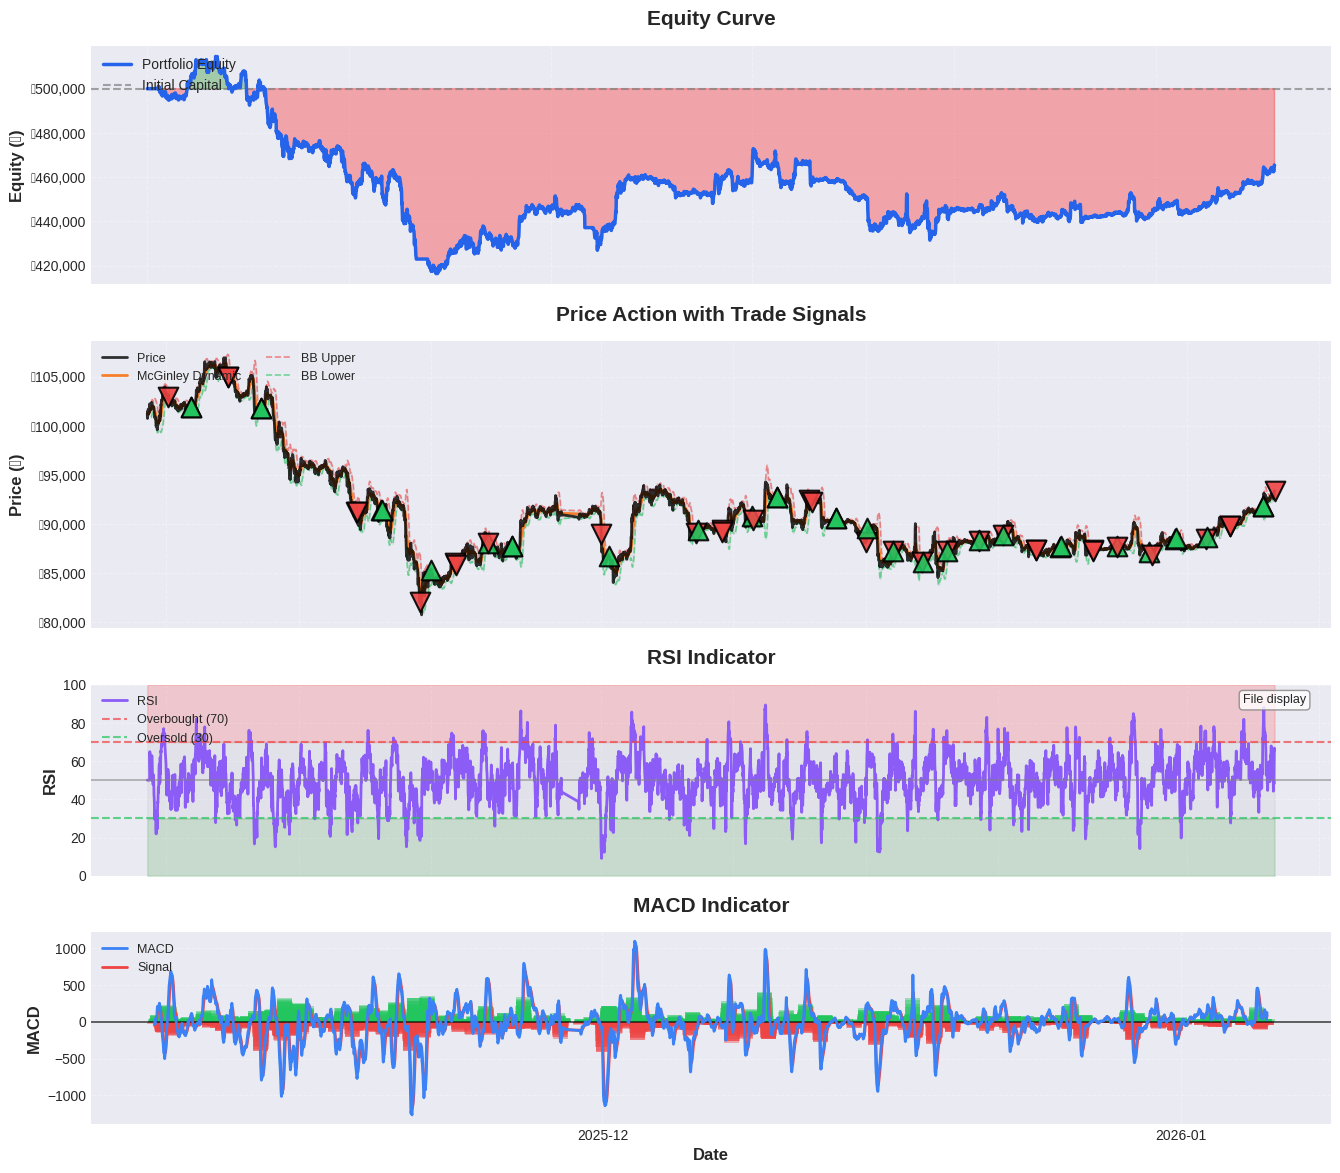

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import logging
import ccxt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import seaborn as sns

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('mexc_trading_bot.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class MEXCTradingBot:
    def __init__(self, api_key, api_secret, initial_capital=500000, risk_per_trade=0.08):
        """
        Enhanced trading bot with comprehensive visualization

        Args:
            api_key: MEXC API key
            api_secret: MEXC API secret
            initial_capital: Starting capital (₹500,000)
            risk_per_trade: Risk per trade (10%)
        """
        self.api_key = api_key
        self.api_secret = api_secret
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []
        self.is_running = False
        self.client = None

    def connect_mexc(self):
        """Connect to MEXC exchange"""
        try:
            self.client = ccxt.mexc({
                'apiKey': self.api_key,
                'secret': self.api_secret,
                'enableRateLimit': True,
                'options': {'defaultType': 'swap'}
            })

            logger.info("✅ Connected to MEXC")
            balance = self.get_balance()
            logger.info(f"💰 Account Balance: ${balance:,.2f} USDT")
            return True

        except Exception as e:
            logger.error(f"❌ Connection failed: {e}")
            return False

    def get_balance(self):
        """Get USDT balance"""
        try:
            balance = self.client.fetch_balance()
            if 'USDT' in balance['free']:
                return float(balance['free']['USDT'])
            return 0
        except Exception as e:
            logger.error(f"Error getting balance: {e}")
            return 0

    def get_historical_data(self, symbol='BTC/USDT:USDT', timeframe='20m', limit=100):
        """Get historical data from MEXC"""
        try:
            ohlcv = self.client.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                df[col] = df[col].astype(float)

            return df
        except Exception as e:
            logger.error(f"Error getting data: {e}")
            return None

    # ==================== STRATEGY METHODS ====================

    def calculate_mcginley_dynamic(self, prices, period=14, constant=0.6):
        """McGinley Dynamic calculation"""
        md = pd.Series(index=prices.index, dtype=float)
        md.iloc[0] = prices.iloc[0]

        for i in range(1, len(prices)):
            prev_md = md.iloc[i-1]
            price = prices.iloc[i]

            if prev_md == 0 or pd.isna(prev_md):
                md.iloc[i] = price
                continue

            ratio = max(0.5, min(price / prev_md, 2.0))
            n = max(period * (ratio ** 4) * constant, 1.0)
            md.iloc[i] = prev_md + (price - prev_md) / n

        return md

    def calculate_rsi(self, prices, period=14):
        """RSI calculation"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """MACD calculation"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    def calculate_atr(self, high, low, close, period=14):
        """ATR calculation"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.ewm(span=period, adjust=False).mean()
        return atr

    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Bollinger Bands calculation"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band

    def calculate_trend_strength(self, close, md, period=20):
        """Trend strength calculation"""
        price_above_md = (close > md).astype(int)
        trend_strength = price_above_md.rolling(window=period).mean()
        return trend_strength

    def calculate_momentum(self, prices, period=10):
        """Momentum calculation"""
        momentum = prices.diff(period) / prices.shift(period) * 100
        return momentum

    def is_liquid_hour(self, timestamp):
        """Liquidity check"""
        hour = timestamp.hour
        return 0 <= hour <= 10

    def check_long_signal(self, i, close, md, rsi, macd_hist, macd_line,
                         trend_strength, bb_upper, bb_lower, momentum):
        """Long signal logic"""
        if i < 3:
            return False

        price_above_md = close.iloc[i] > md.iloc[i]
        price_cross = (close.iloc[i-1] <= md.iloc[i-1] and close.iloc[i] > md.iloc[i])
        price_signal = price_cross or (price_above_md and close.iloc[i] > close.iloc[i-1])

        rsi_valid = 45 < rsi.iloc[i] < 80

        macd_cross = (macd_hist.iloc[i] > 0 and macd_hist.iloc[i-1] <= 0)
        macd_positive = macd_hist.iloc[i] > 0 and macd_line.iloc[i] > macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_positive

        not_extreme = rsi.iloc[i] < 78
        has_momentum = close.iloc[i] > close.iloc[i-2] or momentum.iloc[i] > -1
        trend_ok = (trend_strength.iloc[i] > 0.3 if not pd.isna(trend_strength.iloc[i]) else True)

        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def check_short_signal(self, i, close, md, rsi, macd_hist, macd_line,
                          trend_strength, bb_upper, bb_lower, momentum):
        """Short signal logic"""
        if i < 3:
            return False

        price_below_md = close.iloc[i] < md.iloc[i]
        price_cross = (close.iloc[i-1] >= md.iloc[i-1] and close.iloc[i] < md.iloc[i])
        price_signal = price_cross or (price_below_md and close.iloc[i] < close.iloc[i-1])

        rsi_valid = 20 < rsi.iloc[i] < 55

        macd_cross = (macd_hist.iloc[i] < 0 and macd_hist.iloc[i-1] >= 0)
        macd_negative = macd_hist.iloc[i] < 0 and macd_line.iloc[i] < macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_negative

        not_extreme = rsi.iloc[i] > 22
        has_momentum = close.iloc[i] < close.iloc[i-2] or momentum.iloc[i] < 1
        trend_ok = (trend_strength.iloc[i] < 0.7 if not pd.isna(trend_strength.iloc[i]) else True)

        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def calculate_position_size(self, price, atr):
        """Position sizing logic"""
        if self.client is None:
            balance = self.capital
        else:
            balance = self.get_balance()

        risk_amount = balance * self.risk_per_trade
        stop_loss_pct = 0.08
        position_size = risk_amount / (price * stop_loss_pct)

        if not np.isnan(atr):
            atr_pct = (atr / price) * 100

            if atr_pct > 3.5:
                position_size *= 0.5
            elif atr_pct > 2.5:
                position_size *= 0.65
            elif atr_pct > 1.5:
                position_size *= 0.8

        max_position = (balance * 0.75) / price
        position_size = min(position_size, max_position)

        min_position = (balance * 0.05) / price
        position_size = max(position_size, min_position)

        position_size = round(position_size, 4)

        return position_size

    def calculate_dynamic_stops(self, entry_price, atr):
        """Stop loss and take profit calculation"""
        tp_pct = 0.12

        if pd.isna(atr):
            sl_pct = 0.10
        else:
            atr_distance = atr / entry_price
            if atr_distance > 0.03:
                sl_pct = 0.12
            elif atr_distance > 0.02:
                sl_pct = 0.11
            else:
                sl_pct = 0.10

        return sl_pct, tp_pct

    # ==================== BACKTEST METHODS ====================

    def download_backtest_data(self, ticker='BTC-USD', interval='20m', period='1d'):
        """Download historical data from Yahoo Finance"""
        print(f"\n📥 Downloading {ticker} data...")
        print(f"   Interval: {interval}, Period: {period}")

        try:
            data = yf.download(ticker, interval=interval, period=period, progress=False)

            if data.empty:
                print("❌ No data downloaded")
                return None

            if isinstance(data.columns, pd.MultiIndex):
                data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

            required = ['Close', 'High', 'Low', 'Open', 'Volume']
            for col in required:
                if col not in data.columns:
                    print(f"❌ Missing column: {col}")
                    return None

            data = data[required]
            print(f"✅ Downloaded {len(data)} bars")
            print(f"   Period: {data.index[0]} to {data.index[-1]}\n")
            return data

        except Exception as e:
            print(f"❌ Error: {e}")
            return None

    def execute_entry_backtest(self, i, close, timestamp, signal_type, position_size, atr):
        """Execute backtest entry"""
        entry_price = close.iloc[i]
        position_value = position_size * entry_price

        if position_value <= self.capital * 0.95:
            sl_pct, tp_pct = self.calculate_dynamic_stops(entry_price, atr)

            if signal_type == 'LONG':
                stop_loss = entry_price * (1 - sl_pct)
                take_profit = entry_price * (1 + tp_pct)
            else:
                stop_loss = entry_price * (1 + sl_pct)
                take_profit = entry_price * (1 - tp_pct)

            self.position = {
                'type': signal_type,
                'entry': entry_price,
                'entry_time': timestamp,
                'entry_bar': i,
                'quantity': position_size,
                'original_quantity': position_size,
                'partial_exited': False,
                'trailing_active': False,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'sl_pct': sl_pct,
                'tp_pct': tp_pct
            }

            self.capital -= position_value
            print(f"\n🔔 {signal_type} Entry @ ${entry_price:.2f}")
            print(f"   Qty: {position_size:.4f} | Value: ${position_value:,.0f}")
            print(f"   SL: ${stop_loss:.2f} ({sl_pct*100:.0f}%) | TP: ${take_profit:.2f} (12%)")

    def check_exit_conditions_backtest(self, i, close, md, rsi):
        """Check backtest exit conditions"""
        current_price = close.iloc[i]
        entry_price = self.position['entry']

        if self.position['type'] == 'LONG':
            pnl_pct = (current_price - entry_price) / entry_price
        else:
            pnl_pct = (entry_price - current_price) / entry_price

        if pnl_pct > 0.08 and not self.position.get('trailing_active'):
            self.position['trailing_active'] = True
            self.position['highest_price'] = current_price
            print(f"  → Trailing stop activated at {pnl_pct*100:.1f}%")

        if self.position.get('trailing_active'):
            if self.position['type'] == 'LONG':
                if current_price > self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = entry_price + (current_price - entry_price) * 0.5
            else:
                if current_price < self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = entry_price - (entry_price - current_price) * 0.5

        if not self.position.get('partial_exited') and pnl_pct >= 0.06:
            exit_qty = self.position['quantity'] * 0.5
            exit_value = exit_qty * current_price
            self.capital += exit_value
            self.position['quantity'] -= exit_qty
            self.position['partial_exited'] = True
            self.position['stop_loss'] = entry_price
            print(f"  ✓ Partial exit (50%) at {pnl_pct*100:.1f}%")

        exit_reason = None

        if self.position.get('trailing_active'):
            ts = self.position.get('trailing_stop', 0)
            if ((self.position['type'] == 'LONG' and current_price < ts) or
                (self.position['type'] == 'SHORT' and current_price > ts)):
                exit_reason = 'Trailing Stop'

        if not exit_reason:
            sl_pct = self.position.get('sl_pct', 0.10)
            tp_pct = self.position.get('tp_pct', 0.12)

            if pnl_pct >= tp_pct:
                exit_reason = 'Take Profit'
            elif pnl_pct <= -sl_pct:
                exit_reason = 'Stop Loss'

        bars_held = i - self.position.get('entry_bar', i)
        if bars_held > 120 and abs(pnl_pct) < 0.03:
            exit_reason = 'Time Stop'

        if not exit_reason:
            if self.position['type'] == 'LONG':
                if close.iloc[i] < md.iloc[i] * 0.97 and rsi.iloc[i] < 40:
                    exit_reason = 'Signal Reversal'
            else:
                if close.iloc[i] > md.iloc[i] * 1.03 and rsi.iloc[i] > 60:
                    exit_reason = 'Signal Reversal'

        return exit_reason

    def execute_exit_backtest(self, i, close, timestamp, exit_reason):
        """Execute backtest exit"""
        current_price = close.iloc[i]
        exit_value = self.position['quantity'] * current_price
        self.capital += exit_value

        original_qty = self.position.get('original_quantity', self.position['quantity'])

        if self.position['type'] == 'LONG':
            pnl = exit_value - (self.position['quantity'] * self.position['entry'])
        else:
            pnl = (self.position['quantity'] * self.position['entry']) - exit_value

        pnl_pct = (pnl / (original_qty * self.position['entry'])) * 100

        trade = {
            'type': self.position['type'],
            'entry': self.position['entry'],
            'entry_time': self.position['entry_time'],
            'exit': current_price,
            'exit_time': timestamp,
            'quantity': self.position['quantity'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'bars_held': i - self.position.get('entry_bar', i)
        }

        self.trades.append(trade)

        emoji = "✅" if pnl > 0 else "❌"
        print(f"{emoji} {exit_reason}: {self.position['type']} | ${current_price:.2f} | P&L: ${pnl:,.0f} ({pnl_pct:.1f}%)")

        self.position = None

    def run_backtest(self, ticker='BTC-USD', interval='15m', period='7d'):
        """Run backtest on historical data"""
        print("\n" + "="*80)
        print("📊 BACKTEST MODE - YOUR EXACT STRATEGY")
        print("="*80)
        print(f"Initial Capital: ${self.initial_capital:,.2f}")
        print(f"Risk per Trade: {self.risk_per_trade*100:.0f}%")
        print("="*80 + "\n")

        data = self.download_backtest_data(ticker, interval, period)
        if data is None:
            return None

        self.capital = self.initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

        close = data['Close']
        high = data['High']
        low = data['Low']

        print("📊 Calculating indicators...")
        md = self.calculate_mcginley_dynamic(close)
        rsi = self.calculate_rsi(close)
        macd_line, signal_line, macd_hist = self.calculate_macd(close)
        atr = self.calculate_atr(high, low, close)
        bb_upper, bb_mid, bb_lower = self.calculate_bollinger_bands(close)
        trend_strength = self.calculate_trend_strength(close, md)
        momentum = self.calculate_momentum(close)

        data['MD'] = md
        data['RSI'] = rsi
        data['MACD_Line'] = macd_line
        data['MACD_Signal'] = signal_line
        data['MACD_Hist'] = macd_hist
        data['ATR'] = atr
        data['BB_Upper'] = bb_upper
        data['BB_Lower'] = bb_lower
        data['Trend_Strength'] = trend_strength
        data['Momentum'] = momentum

        print("✓ Indicators calculated\n")
        print("🔄 Running backtest...\n")

        for i in range(50, len(data)):
            timestamp = data.index[i]

            if not self.is_liquid_hour(timestamp):
                equity = self.capital + (self.position['quantity'] * close.iloc[i] if self.position else 0)
                self.equity_curve.append(equity)
                continue

            if self.position:
                exit_reason = self.check_exit_conditions_backtest(i, close, md, rsi)
                if exit_reason:
                    self.execute_exit_backtest(i, close, timestamp, exit_reason)

            if not self.position:
                position_size = self.calculate_position_size(close.iloc[i], atr.iloc[i])

                if self.check_long_signal(i, close, md, rsi, macd_hist, macd_line,
                                         trend_strength, bb_upper, bb_lower, momentum):
                    self.execute_entry_backtest(i, close, timestamp, 'LONG', position_size, atr.iloc[i])

                elif self.check_short_signal(i, close, md, rsi, macd_hist, macd_line,
                                            trend_strength, bb_upper, bb_lower, momentum):
                    self.execute_entry_backtest(i, close, timestamp, 'SHORT', position_size, atr.iloc[i])

            equity = self.capital + (self.position['quantity'] * close.iloc[i] if self.position else 0)
            self.equity_curve.append(equity)

        if self.position:
            self.execute_exit_backtest(len(data)-1, close, data.index[-1], 'End of Backtest')

        print(f"\n{'='*80}")
        print("✓ Backtest completed")
        print(f"{'='*80}\n")

        return self.generate_backtest_results(data)

    def generate_backtest_results(self, data):
        """Generate backtest statistics"""
        if not self.trades:
            print("⚠️  No trades executed")
            return None

        trades_df = pd.DataFrame(self.trades)

        total_return = ((self.capital - self.initial_capital) / self.initial_capital) * 100
        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]

        win_rate = len(winning_trades) / len(trades_df) * 100
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['pnl'].mean()) if len(losing_trades) > 0 else 0
        profit_factor = avg_win / avg_loss if avg_loss > 0 else 0

        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min())

        returns = equity_series.pct_change().dropna()
        sharpe = ((returns.mean() / returns.std()) * np.sqrt(252 * 24) if returns.std() > 0 else 0)

        total_long = len(trades_df[trades_df['type'] == 'LONG'])
        total_short = len(trades_df[trades_df['type'] == 'SHORT'])
        avg_bars_held = trades_df['bars_held'].mean()

        win_streak = 0
        loss_streak = 0
        current_streak = 0
        for pnl in trades_df['pnl']:
            if pnl > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
                win_streak = max(win_streak, current_streak)
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
                loss_streak = max(loss_streak, abs(current_streak))

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': len(trades_df),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'total_long': total_long,
            'total_short': total_short,
            'avg_bars_held': avg_bars_held,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve,
            'data': data
        }

    def plot_comprehensive_results(self, results):
        """
        Create comprehensive visualization matching your desired format
        """
        if not results:
            print("⚠️  No results to plot")
            return

        data = results['data']
        trades_df = results['trades_df']

        # Create figure with 4 subplots
        fig = plt.figure(figsize=(16, 14))
        gs = fig.add_gridspec(4, 1, hspace=0.25, height_ratios=[1, 1.2, 0.8, 0.8])

        # ==================== 1. EQUITY CURVE ====================
        ax1 = fig.add_subplot(gs[0])
        equity = results['equity_curve']

        ax1.plot(equity, linewidth=2.5, color='#2563eb', label='Portfolio Equity', zorder=3)
        ax1.axhline(self.initial_capital, color='gray', linestyle='--',
                   linewidth=1.5, alpha=0.7, label='Initial Capital', zorder=2)

        # Fill between
        ax1.fill_between(range(len(equity)), equity, self.initial_capital,
                        where=(np.array(equity) >= self.initial_capital),
                        alpha=0.3, color='green', interpolate=True, zorder=1)
        ax1.fill_between(range(len(equity)), equity, self.initial_capital,
                        where=(np.array(equity) < self.initial_capital),
                        alpha=0.3, color='red', interpolate=True, zorder=1)

        ax1.set_title('Equity Curve', fontsize=15, fontweight='bold', pad=15)
        ax1.set_ylabel('Equity (₹)', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=10)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

        # ==================== 2. PRICE ACTION WITH TRADE SIGNALS ====================
        ax2 = fig.add_subplot(gs[1])

        # Plot price and indicators
        ax2.plot(data.index, data['Close'], label='Price',
                linewidth=2, color='black', alpha=0.8, zorder=3)
        ax2.plot(data.index, data['MD'], label='McGinley Dynamic',
                linewidth=2, color='#f97316', alpha=0.9, zorder=2)
        ax2.plot(data.index, data['BB_Upper'], label='BB Upper',
                linewidth=1.2, color='#ef4444', alpha=0.6, linestyle='--', zorder=1)
        ax2.plot(data.index, data['BB_Lower'], label='BB Lower',
                linewidth=1.2, color='#22c55e', alpha=0.6, linestyle='--', zorder=1)

        # Fill Bollinger Bands
        ax2.fill_between(data.index, data['BB_Upper'], data['BB_Lower'],
                        alpha=0.1, color='gray', zorder=0)

        # Plot trade signals
        for trade in trades_df.itertuples():
            if trade.type == 'LONG':
                # Long entry (green up arrow)
                ax2.scatter(trade.entry_time, trade.entry,
                          color='#22c55e', marker='^', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
                # Long exit (red down arrow)
                ax2.scatter(trade.exit_time, trade.exit,
                          color='#ef4444', marker='v', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
            else:
                # Short entry (red down arrow)
                ax2.scatter(trade.entry_time, trade.entry,
                          color='#ef4444', marker='v', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)
                # Short exit (green up arrow)
                ax2.scatter(trade.exit_time, trade.exit,
                          color='#22c55e', marker='^', s=200,
                          edgecolors='black', linewidths=1.5, zorder=5, alpha=0.9)

        ax2.set_title('Price Action with Trade Signals', fontsize=15, fontweight='bold', pad=15)
        ax2.set_ylabel('Price (₹)', fontsize=12, fontweight='bold')
        ax2.legend(loc='upper left', fontsize=9, ncol=2)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₹{x:,.0f}'))

        # ==================== 3. RSI INDICATOR ====================
        ax3 = fig.add_subplot(gs[2])

        ax3.plot(data.index, data['RSI'], linewidth=2, color='#8b5cf6', label='RSI')

        # RSI zones
        ax3.axhline(50, color='gray', linestyle='-', linewidth=1.2, alpha=0.6)
        ax3.axhline(70, color='#ef4444', linestyle='--', linewidth=1.5,
                   alpha=0.7, label='Overbought (70)')
        ax3.axhline(30, color='#22c55e', linestyle='--', linewidth=1.5,
                   alpha=0.7, label='Oversold (30)')

        # Fill overbought/oversold zones
        ax3.fill_between(data.index, 70, 100, alpha=0.15, color='red')
        ax3.fill_between(data.index, 0, 30, alpha=0.15, color='green')
        ax3.fill_between(data.index, 30, 70, alpha=0.08, color='gray')

        # Add file display label (as shown in your image)
        ax3.text(0.98, 0.95, 'File display', transform=ax3.transAxes,
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))

        ax3.set_title('RSI Indicator', fontsize=15, fontweight='bold', pad=15)
        ax3.set_ylabel('RSI', fontsize=12, fontweight='bold')
        ax3.set_ylim([0, 100])
        ax3.legend(loc='upper left', fontsize=9)
        ax3.grid(True, alpha=0.3, linestyle='--')

        # ==================== 4. MACD INDICATOR ====================
        ax4 = fig.add_subplot(gs[3])

        ax4.plot(data.index, data['MACD_Line'], label='MACD',
                linewidth=2, color='#3b82f6', zorder=3)
        ax4.plot(data.index, data['MACD_Signal'], label='Signal',
                linewidth=2, color='#ef4444', zorder=2)

        # MACD histogram with colors
        colors = ['#22c55e' if x > 0 else '#ef4444' for x in data['MACD_Hist']]
        ax4.bar(data.index, data['MACD_Hist'], alpha=0.4, color=colors,
               width=0.8, edgecolor='none', zorder=1)

        ax4.axhline(0, color='black', linestyle='-', linewidth=1.2, alpha=0.7)

        ax4.set_title('MACD Indicator', fontsize=15, fontweight='bold', pad=15)
        ax4.set_ylabel('MACD', fontsize=12, fontweight='bold')
        ax4.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax4.legend(loc='upper left', fontsize=9)
        ax4.grid(True, alpha=0.3, linestyle='--')

        # Format x-axis dates
        ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax4.xaxis.set_major_locator(mdates.MonthLocator())
        plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0, ha='center')

        # Apply same date formatting to other axes
        for ax in [ax1, ax2, ax3]:
            ax.set_xticklabels([])

        plt.tight_layout()

        # Save figure
        filename = f'backtest_detailed_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\n📊 Comprehensive chart saved as '{filename}'")
        plt.show()

    def print_detailed_results(self, results):
        """Print detailed backtest results"""
        if not results:
            return

        print("\n" + "="*80)
        print("📈 COMPREHENSIVE BACKTEST RESULTS")
        print("="*80 + "\n")

        # Performance Summary
        print("💰 PERFORMANCE SUMMARY")
        print("-" * 80)
        print(f"  Initial Capital:         ₹{results['initial_capital']:>15,.2f}")
        print(f"  Final Capital:           ₹{results['final_capital']:>15,.2f}")
        pnl = results['final_capital'] - results['initial_capital']
        pnl_color = "+" if pnl >= 0 else ""
        print(f"  Net P&L:                 {pnl_color}₹{pnl:>14,.2f}")
        print(f"  Total Return:            {results['total_return']:>15.2f}%")
        print(f"  Max Drawdown:            {results['max_drawdown']:>15.2f}%")
        print(f"  Sharpe Ratio:            {results['sharpe_ratio']:>15.2f}")

        # Trade Statistics
        print(f"\n📊 TRADE STATISTICS")
        print("-" * 80)
        print(f"  Total Trades:            {results['total_trades']:>15}")
        print(f"  Long Trades:             {results['total_long']:>15}")
        print(f"  Short Trades:            {results['total_short']:>15}")
        print(f"  Winning Trades:          {results['winning_trades']:>15}")
        print(f"  Losing Trades:           {results['losing_trades']:>15}")
        print(f"  Win Rate:                {results['win_rate']:>14.2f}%")
        print(f"  Average Bars Held:       {results.get('avg_bars_held', 0):>15.1f}")

        # Profitability Metrics
        print(f"\n💵 PROFITABILITY METRICS")
        print("-" * 80)
        print(f"  Average Win:             ₹{results['avg_win']:>15,.2f}")
        print(f"  Average Loss:            ₹{results['avg_loss']:>15,.2f}")
        print(f"  Profit Factor:           {results['profit_factor']:>15.2f}")
        print(f"  Max Win Streak:          {results.get('max_win_streak', 0):>15}")
        print(f"  Max Loss Streak:         {results.get('max_loss_streak', 0):>15}")

        # Trade Details
        print(f"\n{'='*80}")
        print("📋 RECENT TRADES (Last 10)")
        print("="*80)
        print(f"{'Type':<7} {'Entry':>10} {'Exit':>10} {'P&L%':>8} {'P&L':>12} {'Reason':<20}")
        print("-" * 80)

        for idx, trade in results['trades_df'].tail(10).iterrows():
            emoji = "✅" if trade['pnl'] > 0 else "❌"
            print(f"{emoji} {trade['type']:<5} "
                  f"₹{trade['entry']:>8,.2f} "
                  f"₹{trade['exit']:>8,.2f} "
                  f"{trade['pnl_pct']:>7.2f}% "
                  f"₹{trade['pnl']:>10,.2f} "
                  f"{trade['exit_reason']:<20}")

        print(f"\n{'='*80}")
        print("✅ BACKTEST ANALYSIS COMPLETE!")
        print(f"{'='*80}\n")


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🤖 ENHANCED MEXC TRADING BOT - BTC STRATEGY")
    print("="*80)
    print("\n📌 FEATURES:")
    print("  ✓ Comprehensive backtest with detailed visualization")
    print("  ✓ Live trading on MEXC")
    print("  ✓ Advanced position sizing & risk management")
    print("  ✓ Multiple exit strategies (TP, SL, Trailing, Time-based)")
    print("\n📊 VISUALIZATION:")
    print("  • Equity curve with profit/loss zones")
    print("  • Price action with trade entry/exit markers")
    print("  • RSI indicator with overbought/oversold zones")
    print("  • MACD with histogram")
    print("="*80 + "\n")

    mode = input("Enter mode (1=Backtest, 2=Live): ").strip()

    if mode == "1":
        print("\n🔍 BACKTEST MODE SELECTED")
        print("="*80)

        bot = MEXCTradingBot(
            api_key="",
            api_secret="",
            initial_capital=500000,
            risk_per_trade=0.08
        )

        results = bot.run_backtest(
            ticker='BTC-USD',
            interval='15m',
            period='60d'
        )

        if results:
            bot.print_detailed_results(results)
            bot.plot_comprehensive_results(results)

    elif mode == "2":
        print("\n⚠️ LIVE TRADING MODE")
        print("Live trading functionality requires API implementation")
        print("Please ensure you have tested thoroughly in backtest mode first!")

    else:
        print("❌ Invalid selection")

In [ ]:
!pip install pybit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.2 MB/s eta 0:00:00
  Created wheel for pybit: filename=pybit-5.13.0-py2.py3-none-any.whl size=46161 sha256=e455747576d5fbf34bc8b76e71516f5c114386d6f05618fae9903024260a3b88
  Stored in directory: /root/.cache/pip/wheels/fc/1a/d7/685c4b890f8bd158440312df09b26505fc53b558cfe975addf
Successfully built pybit


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class AdvancedTradingStrategy:
    def __init__(self, initial_capital=500000, risk_per_trade=0.10):
        """
        Enhanced trading strategy with improved accuracy

        Args:
            initial_capital: Starting capital in INR
            risk_per_trade: Risk percentage per trade (default 10%)
        """
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

    def calculate_mcginley_dynamic(self, prices, period=14, constant=0.6):
        """Calculate McGinley Dynamic - adaptive moving average"""
        md = pd.Series(index=prices.index, dtype=float)
        md.iloc[0] = prices.iloc[0]

        for i in range(1, len(prices)):
            prev_md = md.iloc[i-1]
            price = prices.iloc[i]

            if prev_md == 0 or pd.isna(prev_md):
                md.iloc[i] = price
                continue

            ratio = max(0.5, min(price / prev_md, 2.0))
            n = max(period * (ratio ** 4) * constant, 1.0)
            md.iloc[i] = prev_md + (price - prev_md) / n

        return md

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI with Wilder's smoothing"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD indicator"""
        ema_fast = prices.ewm(span=fast, adjust=False).mean()
        ema_slow = prices.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return macd_line, signal_line, histogram

    def calculate_atr(self, high, low, close, period=14):
        """Calculate Average True Range"""
        high_low = high - low
        high_close = np.abs(high - close.shift())
        low_close = np.abs(low - close.shift())

        ranges = pd.concat([high_low, high_close, low_close], axis=1)
        true_range = ranges.max(axis=1)
        atr = true_range.ewm(span=period, adjust=False).mean()
        return atr

    def calculate_bollinger_bands(self, prices, period=20, std_dev=2):
        """Calculate Bollinger Bands"""
        sma = prices.rolling(window=period).mean()
        std = prices.rolling(window=period).std()
        upper_band = sma + (std * std_dev)
        lower_band = sma - (std * std_dev)
        return upper_band, sma, lower_band

    def calculate_trend_strength(self, close, md, period=20):
        """Calculate trend strength (0-1 scale)"""
        price_above_md = (close > md).astype(int)
        trend_strength = price_above_md.rolling(window=period).mean()
        return trend_strength

    def calculate_volume_profile(self, volume, period=20):
        """Calculate volume trend"""
        vol_ma = volume.rolling(window=period).mean()
        vol_ratio = volume / vol_ma
        return vol_ratio

    def calculate_momentum(self, prices, period=10):
        """Calculate price momentum"""
        momentum = prices.diff(period) / prices.shift(period) * 100
        return momentum

    def is_liquid_hour(self, timestamp):
        """Check if trading during high liquidity hours"""
        hour = timestamp.hour
        return 0 <= hour <= 10  # Extended for crypto markets

    def check_long_signal(self, i, close, md, rsi, macd_hist, macd_line,
                         trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced long entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses above McGinley Dynamic OR price above MD with momentum
        2. RSI > 45 (bullish territory)
        3. MACD bullish (crossover OR already positive with upward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_above_md = close.iloc[i] > md.iloc[i]
        price_cross = (close.iloc[i-1] <= md.iloc[i-1] and
                      close.iloc[i] > md.iloc[i])
        # Accept if crossing OR already above with momentum
        price_signal = price_cross or (price_above_md and close.iloc[i] > close.iloc[i-1])

        # Core Signal 2: RSI in bullish zone (relaxed from 50-75 to 45-80)
        rsi_valid = 45 < rsi.iloc[i] < 80

        # Core Signal 3: MACD bullish (crossover OR positive with momentum)
        macd_cross = (macd_hist.iloc[i] > 0 and macd_hist.iloc[i-1] <= 0)
        macd_positive = macd_hist.iloc[i] > 0 and macd_line.iloc[i] > macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_positive

        # Confirmation 1: Not in extreme overbought (relaxed)
        not_extreme = rsi.iloc[i] < 78

        # Confirmation 2: Some positive momentum
        has_momentum = close.iloc[i] > close.iloc[i-2] or momentum.iloc[i] > -1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] > 0.3 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def check_short_signal(self, i, close, md, rsi, macd_hist, macd_line,
                          trend_strength, bb_upper, bb_lower, momentum):
        """
        Enhanced short entry signal - balanced conditions

        Requirements (relaxed for better signal generation):
        1. Price crosses below McGinley Dynamic OR price below MD with momentum
        2. RSI < 55 (bearish territory)
        3. MACD bearish (crossover OR already negative with downward momentum)
        4. Basic trend confirmation
        """
        if i < 3:
            return False

        # Core Signal 1: Price position relative to MD
        price_below_md = close.iloc[i] < md.iloc[i]
        price_cross = (close.iloc[i-1] >= md.iloc[i-1] and
                      close.iloc[i] < md.iloc[i])
        # Accept if crossing OR already below with momentum
        price_signal = price_cross or (price_below_md and close.iloc[i] < close.iloc[i-1])

        # Core Signal 2: RSI in bearish zone (relaxed from 25-50 to 20-55)
        rsi_valid = 20 < rsi.iloc[i] < 55

        # Core Signal 3: MACD bearish (crossover OR negative with momentum)
        macd_cross = (macd_hist.iloc[i] < 0 and macd_hist.iloc[i-1] >= 0)
        macd_negative = macd_hist.iloc[i] < 0 and macd_line.iloc[i] < macd_line.iloc[i-1]
        macd_signal = macd_cross or macd_negative

        # Confirmation 1: Not in extreme oversold (relaxed)
        not_extreme = rsi.iloc[i] > 22

        # Confirmation 2: Some negative momentum
        has_momentum = close.iloc[i] < close.iloc[i-2] or momentum.iloc[i] < 1

        # Confirmation 3: Trend direction (relaxed)
        trend_ok = (trend_strength.iloc[i] < 0.7 if
                   not pd.isna(trend_strength.iloc[i]) else True)

        # Combine conditions (more lenient)
        core_signals = price_signal and rsi_valid and macd_signal
        confirmations = not_extreme and has_momentum and trend_ok

        return core_signals and confirmations

    def calculate_position_size(self, price, atr, volatility_pct=None):
        """
        Dynamic position sizing based on volatility and risk management

        Args:
            price: Current price
            atr: Average True Range
            volatility_pct: Volatility percentile (0-1)
        """
        # Base risk amount
        risk_amount = self.capital * self.risk_per_trade

        # Calculate base position size (10% stop loss)
        stop_loss_pct = 0.10
        position_size = risk_amount / (price * stop_loss_pct)

        # Adjust for ATR-based volatility
        if not np.isnan(atr):
            atr_pct = (atr / price) * 100

            if atr_pct > 3.5:  # Very high volatility
                position_size *= 0.5
            elif atr_pct > 2.5:  # High volatility
                position_size *= 0.65
            elif atr_pct > 1.5:  # Medium volatility
                position_size *= 0.8
            # Low volatility: keep full size

        # Maximum 75% of capital (conservative)
        max_position = (self.capital * 0.75) / price
        position_size = min(position_size, max_position)

        # Minimum 5% of capital
        min_position = (self.capital * 0.05) / price
        position_size = max(position_size, min_position)

        return position_size

    def calculate_dynamic_stops(self, entry_price, atr, position_type):
        """Calculate fixed stop loss and take profit"""
        # Fixed 12% take profit
        tp_pct = 0.12

        # Stop loss between 10-12% based on volatility
        if pd.isna(atr):
            sl_pct = 0.10
        else:
            atr_distance = atr / entry_price
            # If high volatility, use wider stop (up to 12%)
            if atr_distance > 0.03:
                sl_pct = 0.12
            elif atr_distance > 0.02:
                sl_pct = 0.11
            else:
                sl_pct = 0.10

        if position_type == 'LONG':
            stop_loss = entry_price * (1 - sl_pct)
            take_profit = entry_price * (1 + tp_pct)
        else:
            stop_loss = entry_price * (1 + sl_pct)
            take_profit = entry_price * (1 - tp_pct)

        return stop_loss, take_profit, sl_pct, tp_pct

    def check_exit_conditions(self, i, close, md, rsi):
        """
        Enhanced exit logic with trailing stop
        """
        current_price = close.iloc[i]
        entry_price = self.position['entry']

        # Calculate P&L
        if self.position['type'] == 'LONG':
            pnl_pct = (current_price - entry_price) / entry_price
        else:
            pnl_pct = (entry_price - current_price) / entry_price

        # Activate trailing stop at 8% profit
        if pnl_pct > 0.08 and not self.position.get('trailing_active'):
            self.position['trailing_active'] = True
            self.position['highest_price'] = current_price
            print(f"  → Trailing stop activated at {pnl_pct*100:.1f}% profit")

        # Update trailing stop
        if self.position.get('trailing_active'):
            if self.position['type'] == 'LONG':
                if current_price > self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    # Lock in 50% of profit
                    self.position['trailing_stop'] = (
                        entry_price + (current_price - entry_price) * 0.5
                    )
            else:
                if current_price < self.position['highest_price']:
                    self.position['highest_price'] = current_price
                    self.position['trailing_stop'] = (
                        entry_price - (entry_price - current_price) * 0.5
                    )

        # Partial exit at 6% profit
        if not self.position.get('partial_exited') and pnl_pct >= 0.06:
            exit_qty = self.position['quantity'] * 0.5
            exit_value = exit_qty * current_price
            self.capital += exit_value
            self.position['quantity'] -= exit_qty
            self.position['partial_exited'] = True

            # Move stop to breakeven
            self.position['stop_loss'] = entry_price

            print(f"  ✓ Partial exit (50%) at {pnl_pct*100:.1f}% profit")

        # Check exit conditions
        exit_reason = None

        # 1. Trailing stop
        if self.position.get('trailing_active'):
            ts = self.position.get('trailing_stop', 0)
            if ((self.position['type'] == 'LONG' and current_price < ts) or
                (self.position['type'] == 'SHORT' and current_price > ts)):
                exit_reason = 'Trailing Stop'

        # 2. Stop loss and take profit
        if not exit_reason:
            sl_pct = self.position.get('sl_pct', 0.10)
            tp_pct = self.position.get('tp_pct', 0.15)

            if pnl_pct >= tp_pct:
                exit_reason = 'Take Profit'
            elif pnl_pct <= -sl_pct:
                exit_reason = 'Stop Loss'

        # 3. Time-based exit (prevent dead trades)
        bars_held = i - self.position.get('entry_bar', i)
        if bars_held > 120 and abs(pnl_pct) < 0.03:
            exit_reason = 'Time Stop'

        # 4. Signal reversal (strong opposite signal)
        if not exit_reason:
            if self.position['type'] == 'LONG':
                if close.iloc[i] < md.iloc[i] * 0.97 and rsi.iloc[i] < 40:
                    exit_reason = 'Signal Reversal'
            else:
                if close.iloc[i] > md.iloc[i] * 1.03 and rsi.iloc[i] > 60:
                    exit_reason = 'Signal Reversal'

        return exit_reason

    def execute_exit(self, i, close, timestamp, exit_reason):
        """Execute exit with P&L calculation"""
        current_price = close.iloc[i]
        exit_value = self.position['quantity'] * current_price
        self.capital += exit_value

        # Calculate P&L
        original_qty = self.position.get('original_quantity', self.position['quantity'])
        if self.position['type'] == 'LONG':
            pnl = exit_value - (self.position['quantity'] * self.position['entry'])
        else:
            pnl = (self.position['quantity'] * self.position['entry']) - exit_value

        pnl_pct = (pnl / (original_qty * self.position['entry'])) * 100

        # Record trade
        trade = {
            'type': self.position['type'],
            'entry': self.position['entry'],
            'entry_time': self.position['entry_time'],
            'exit': current_price,
            'exit_time': timestamp,
            'quantity': self.position['quantity'],
            'pnl': pnl,
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'bars_held': i - self.position.get('entry_bar', i)
        }

        self.trades.append(trade)

        emoji = "✅" if pnl > 0 else "❌"
        print(f"{emoji} {exit_reason}: {self.position['type']} | "
              f"₹{current_price:.2f} | P&L: ₹{pnl:,.0f} ({pnl_pct:.1f}%)")

        self.position = None

    def execute_entry(self, i, close, timestamp, signal_type, position_size, atr):
        """Execute entry trade"""
        entry_price = close.iloc[i]
        position_value = position_size * entry_price

        if position_value <= self.capital * 0.95:
            sl, tp, sl_pct, tp_pct = self.calculate_dynamic_stops(
                entry_price, atr, signal_type
            )

            self.position = {
                'type': signal_type,
                'entry': entry_price,
                'entry_time': timestamp,
                'entry_bar': i,
                'quantity': position_size,
                'original_quantity': position_size,
                'partial_exited': False,
                'trailing_active': False,
                'stop_loss': sl,
                'take_profit': tp,
                'sl_pct': sl_pct,
                'tp_pct': tp_pct
            }

            self.capital -= position_value

            print(f"\n🔔 {signal_type} Entry @ ₹{entry_price:.2f}")
            print(f"  Quantity: {position_size:.4f} | Value: ₹{position_value:,.0f}")
            print(f"  Stop Loss: ₹{sl:.2f} ({sl_pct*100:.0f}%) | Take Profit: ₹{tp:.2f} (12%)")

    def backtest(self, data):
        """Run complete backtest"""
        print(f"\n{'='*80}")
        print(f"🚀 STARTING ADVANCED BACKTEST")
        print(f"{'='*80}")
        print(f"Initial Capital: ₹{self.initial_capital:,.2f}")
        print(f"Risk per Trade: {self.risk_per_trade*100:.0f}%")
        print(f"Data Period: {data.index[0]} to {data.index[-1]}")
        print(f"Total Bars: {len(data)}")
        print(f"{'='*80}\n")

        # Calculate all indicators
        close = data['Close']
        high = data['High']
        low = data['Low']
        volume = data['Volume']

        print("📊 Calculating indicators...")
        md = self.calculate_mcginley_dynamic(close)
        rsi = self.calculate_rsi(close)
        macd_line, signal_line, macd_hist = self.calculate_macd(close)
        atr = self.calculate_atr(high, low, close)
        bb_upper, bb_mid, bb_lower = self.calculate_bollinger_bands(close)
        trend_strength = self.calculate_trend_strength(close, md)
        momentum = self.calculate_momentum(close)

        # Add to dataframe
        data['MD'] = md
        data['RSI'] = rsi
        data['MACD_Line'] = macd_line
        data['MACD_Signal'] = signal_line
        data['MACD_Hist'] = macd_hist
        data['ATR'] = atr
        data['BB_Upper'] = bb_upper
        data['BB_Lower'] = bb_lower
        data['Trend_Strength'] = trend_strength
        data['Momentum'] = momentum

        print("✓ Indicators calculated\n")
        print("🔄 Running backtest...\n")

        # Backtest loop
        for i in range(50, len(data)):
            timestamp = data.index[i]

            # Time filter
            if not self.is_liquid_hour(timestamp):
                equity = self.capital + (
                    self.position['quantity'] * close.iloc[i]
                    if self.position else 0
                )
                self.equity_curve.append(equity)
                continue

            # Exit management
            if self.position:
                exit_reason = self.check_exit_conditions(i, close, md, rsi)
                if exit_reason:
                    self.execute_exit(i, close, timestamp, exit_reason)

            # Entry signals
            if not self.position:
                position_size = self.calculate_position_size(
                    close.iloc[i], atr.iloc[i]
                )

                # Check long
                if self.check_long_signal(i, close, md, rsi, macd_hist,
                                         macd_line, trend_strength,
                                         bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'LONG',
                                     position_size, atr.iloc[i])

                # Check short
                elif self.check_short_signal(i, close, md, rsi, macd_hist,
                                            macd_line, trend_strength,
                                            bb_upper, bb_lower, momentum):
                    self.execute_entry(i, close, timestamp, 'SHORT',
                                     position_size, atr.iloc[i])

            # Record equity
            equity = self.capital + (
                self.position['quantity'] * close.iloc[i]
                if self.position else 0
            )
            self.equity_curve.append(equity)

        # Close final position
        if self.position:
            self.execute_exit(len(data)-1, close, data.index[-1], 'End of Backtest')

        print(f"\n{'='*80}")
        print("✓ Backtest completed")
        print(f"{'='*80}\n")

        return self.generate_results()

    def generate_results(self):
        """Generate comprehensive statistics"""
        if not self.trades:
            print("⚠️  No trades executed")
            return None

        trades_df = pd.DataFrame(self.trades)

        # Performance metrics
        total_return = ((self.capital - self.initial_capital) /
                       self.initial_capital) * 100

        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]

        win_rate = len(winning_trades) / len(trades_df) * 100
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = abs(losing_trades['pnl'].mean()) if len(losing_trades) > 0 else 0
        profit_factor = avg_win / avg_loss if avg_loss > 0 else 0

        # Risk metrics
        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min())

        # Sharpe ratio (annualized for hourly data)
        returns = equity_series.pct_change().dropna()
        sharpe = ((returns.mean() / returns.std()) * np.sqrt(252 * 24)
                 if returns.std() > 0 else 0)

        # Additional metrics
        total_long = len(trades_df[trades_df['type'] == 'LONG'])
        total_short = len(trades_df[trades_df['type'] == 'SHORT'])
        avg_bars = trades_df['bars_held'].mean()

        # Consecutive wins/losses
        win_streak = 0
        loss_streak = 0
        current_streak = 0
        for pnl in trades_df['pnl']:
            if pnl > 0:
                current_streak = current_streak + 1 if current_streak > 0 else 1
                win_streak = max(win_streak, current_streak)
            else:
                current_streak = current_streak - 1 if current_streak < 0 else -1
                loss_streak = max(loss_streak, abs(current_streak))

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': len(trades_df),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'total_long': total_long,
            'total_short': total_short,
            'avg_bars_held': avg_bars,
            'max_win_streak': win_streak,
            'max_loss_streak': loss_streak,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve
        }

    def print_results(self, results):
        """Print formatted results"""
        if not results:
            return

        print(f"{'='*80}")
        print("📈 BACKTEST RESULTS")
        print(f"{'='*80}\n")

        print("💰 CAPITAL PERFORMANCE")
        print(f"  Initial Capital:     ₹{results['initial_capital']:>12,.0f}")
        print(f"  Final Capital:       ₹{results['final_capital']:>12,.0f}")
        print(f"  Total Return:        {results['total_return']:>12.2f}%")
        print(f"  Max Drawdown:        {results['max_drawdown']:>12.2f}%")
        print(f"  Sharpe Ratio:        {results['sharpe_ratio']:>12.2f}")

        print(f"\n📊 TRADE STATISTICS")
        print(f"  Total Trades:        {results['total_trades']:>12}")
        print(f"  Long Trades:         {results['total_long']:>12}")
        print(f"  Short Trades:        {results['total_short']:>12}")
        print(f"  Winning Trades:      {results['winning_trades']:>12}")
        print(f"  Losing Trades:       {results['losing_trades']:>12}")
        print(f"  Win Rate:            {results['win_rate']:>12.1f}%")
        print(f"  Avg Bars Held:       {results['avg_bars_held']:>12.1f}")

        print(f"\n💵 PROFITABILITY")
        print(f"  Average Win:         ₹{results['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹{results['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:       {results['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:      {results['max_win_streak']:>12}")
        print(f"  Max Loss Streak:     {results['max_loss_streak']:>12}")

        print(f"\n{'='*80}")
        print("📋 LAST 10 TRADES")
        print(f"{'='*80}\n")

        for idx, trade in results['trades_df'].tail(10).iterrows():
            emoji = "✅" if trade['pnl'] > 0 else "❌"
            print(f"{emoji} {trade['type']:5} | Entry: ₹{trade['entry']:8.2f} | "
                  f"Exit: ₹{trade['exit']:8.2f} | P&L: {trade['pnl_pct']:6.1f}% | "
                  f"{trade['exit_reason']}")

        print(f"\n{'='*80}\n")

    def plot_results(self, results, data):
        """Create comprehensive visualization"""
        if not results:
            return

        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(4, 1, hspace=0.3)

        # 1. Equity Curve
        ax1 = fig.add_subplot(gs[0])
        equity = results['equity_curve']
        ax1.plot(equity, linewidth=2, color='#2563eb')
        ax1.axhline(self.initial_capital, color='gray',
                   linestyle='--', alpha=0.5, label='Initial Capital')
        ax1.fill_between(range(len(equity)), equity,
                        self.initial_capital, alpha=0.2)
        ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Equity (₹)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Price with trades
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(data.index, data['Close'], label='Price',
                linewidth=1.5, color='black', alpha=0.7)
        ax2.plot(data.index, data['MD'], label='McGinley Dynamic',
                linewidth=1.5, color='orange')
        ax2.plot(data.index, data['BB_Upper'], label='BB Upper',
                linewidth=0.8, color='red', alpha=0.5, linestyle='--')
        ax2.plot(data.index, data['BB_Lower'], label='BB Lower',
                linewidth=0.8, color='green', alpha=0.5, linestyle='--')

        # Plot trade signals
        for trade in results['trades_df'].itertuples():
            if trade.type == 'LONG':
                ax2.scatter(trade.entry_time, trade.entry, color='green',
                          marker='^', s=120, zorder=5, edgecolors='black', linewidths=1)
                ax2.scatter(trade.exit_time, trade.exit, color='red',
                          marker='v', s=120, zorder=5, edgecolors='black', linewidths=1)
            else:
                ax2.scatter(trade.entry_time, trade.entry, color='red',
                          marker='v', s=120, zorder=5, edgecolors='black', linewidths=1)
                ax2.scatter(trade.exit_time, trade.exit, color='green',
                          marker='^', s=120, zorder=5, edgecolors='black', linewidths=1)

        ax2.set_title('Price Action with Trade Signals', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Price (₹)')
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        # 3. RSI
        ax3 = fig.add_subplot(gs[2])
        ax3.plot(data.index, data['RSI'], linewidth=1.5, color='purple')
        ax3.axhline(50, color='gray', linestyle='-', linewidth=1, alpha=0.5)
        ax3.axhline(70, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Overbought')
        ax3.axhline(30, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Oversold')
        ax3.fill_between(data.index, 30, 70, alpha=0.1, color='gray')
        ax3.set_title('RSI Indicator', fontsize=14, fontweight='bold')
        ax3.set_ylabel('RSI')
        ax3.set_ylim([0, 100])
        ax3.legend(loc='upper left')
        ax3.grid(True, alpha=0.3)

        # 4. MACD
        ax4 = fig.add_subplot(gs[3])
        ax4.plot(data.index, data['MACD_Line'], label='MACD',
                linewidth=1.3, color='blue')
        ax4.plot(data.index, data['MACD_Signal'], label='Signal',
                linewidth=1.3, color='red')

        # MACD histogram
        colors = ['green' if x > 0 else 'red' for x in data['MACD_Hist']]
        ax4.bar(data.index, data['MACD_Hist'], alpha=0.3, color=colors, width=0.8)
        ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
        ax4.set_title('MACD Indicator', fontsize=14, fontweight='bold')
        ax4.set_ylabel('MACD')
        ax4.set_xlabel('Date')
        ax4.legend(loc='upper left')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
        print("📊 Chart saved as 'backtest_results.png'")
        plt.show()


def download_data(ticker='BTC-USD', interval='1h', period='60d'):
    """Download historical data from Yahoo Finance"""
    print(f"\n📥 Downloading {ticker} data...")
    print(f"   Interval: {interval}, Period: {period}")

    try:
        data = yf.download(ticker, interval=interval, period=period, progress=False)

        if data.empty:
            print("⚠️  No data downloaded. Using synthetic data.")
            return generate_synthetic_data()

        # Handle MultiIndex columns
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] if isinstance(col, tuple) else col
                          for col in data.columns]

        # Verify required columns
        required = ['Close', 'High', 'Low', 'Open', 'Volume']
        for col in required:
            if col not in data.columns:
                raise ValueError(f"Missing column: {col}")

        data = data[required]
        print(f"✓ Downloaded {len(data)} bars\n")
        return data

    except Exception as e:
        print(f"❌ Error: {e}")
        print("⚠️  Using synthetic data instead.\n")
        return generate_synthetic_data()


def generate_synthetic_data(bars=5000):
    """Generate synthetic price data for testing"""
    print(f"🔧 Generating {bars} bars of synthetic data...")

    dates = pd.date_range(start='2024-01-01', periods=bars, freq='1h')
    price = 50000

    data_list = []
    for i, date in enumerate(dates):
        hour = date.hour

        # Simulate volatility
        volatility = 0.004 if (0 <= hour <= 10) else 0.002
        trend = np.sin(i / 300) * 0.0008
        change = np.random.randn() * volatility + trend

        price = price * (1 + change)
        high = price * (1 + abs(np.random.randn()) * 0.003)
        low = price * (1 - abs(np.random.randn()) * 0.003)
        open_price = price * (1 + np.random.randn() * 0.002)
        volume = np.random.uniform(1000000, 3000000)

        data_list.append({
            'Open': open_price,
            'High': high,
            'Low': low,
            'Close': price,
            'Volume': volume
        })

    df = pd.DataFrame(data_list, index=dates)
    print(f"✓ Generated {len(df)} bars\n")
    return df


if __name__ == "__main__":
    print("\n" + "="*80)
    print("🚀 ADVANCED TRADING STRATEGY BACKTESTER")
    print("   McGinley Dynamic + RSI + MACD + Bollinger Bands")
    print("="*80)

    # Download data
    # Options:
    # - Crypto: 'BTC-USD', 'ETH-USD'
    # - US Stocks: 'AAPL', 'TSLA', 'GOOGL'
    # - Indian Stocks: 'RELIANCE.NS', 'TCS.NS', 'INFY.NS'

    data = download_data(ticker='BTC-USD', interval='15m', period='1d')

    # Or use synthetic data:
    # data = generate_synthetic_data(5000)

    # Initialize strategy
    strategy = AdvancedTradingStrategy(
        initial_capital=500000,  # ₹5 lakhs
        risk_per_trade=0.10      # 10% risk per trade
    )

    # Run backtest
    results = strategy.backtest(data)

    # Print results
    strategy.print_results(results)

    # Plot results
    if results:
        strategy.plot_results(results, data)

    print(f"{'='*80}")
    print("✅ BACKTEST COMPLETE!")
    print(f"{'='*80}\n")


🚀 ADVANCED TRADING STRATEGY BACKTESTER
   McGinley Dynamic + RSI + MACD + Bollinger Bands

📥 Downloading BTC-USD data...
   Interval: 15m, Period: 1d
✓ Downloaded 61 bars


🚀 STARTING ADVANCED BACKTEST
Initial Capital: ₹500,000.00
Risk per Trade: 10%
Data Period: 2026-01-05 00:00:00+00:00 to 2026-01-05 15:00:00+00:00
Total Bars: 61

📊 Calculating indicators...
✓ Indicators calculated

🔄 Running backtest...


✓ Backtest completed

⚠️  No trades executed
✅ BACKTEST COMPLETE!



📈 BACKTEST RESULTS

💰 CAPITAL PERFORMANCE
  Initial Capital:     ₹     500,000
  Final Capital:       ₹     522,586
  Total Return:                4.52%
  Max Drawdown:                5.64%
  Sharpe Ratio:                1.62

📊 TRADE STATISTICS
  Total Trades:                  69
  Long Trades:                   35
  Short Trades:                  34
  Winning Trades:                31
  Losing Trades:                 38
  Win Rate:                    44.9%
  Avg Bars Held:               19.4

💵 PROFITABILITY
  Average Win:         ₹       4,034
  Average Loss:        ₹       2,410
  Profit Factor:               1.37
  Max Win Streak:                 4
  Max Loss Streak:                7

📋 LAST 10 TRADES
 🔴 2025-12-18 13:00:00+00:00 | SHORT | PnL: ₹   -3615 ( -2.28%) | Stop Loss
 🟢 2025-12-18 14:00:00+00:00 | LONG  | PnL: ₹    2264 (  1.44%) | Take Profit
 🔴 2025-12-18 15:00:00+00:00 | LONG  | PnL: ₹   -1743 ( -1.11%) | Stop Loss
 🔴 2025-12-18 17:00:00+00:00 | LONG  | PnL: ₹   -2068 

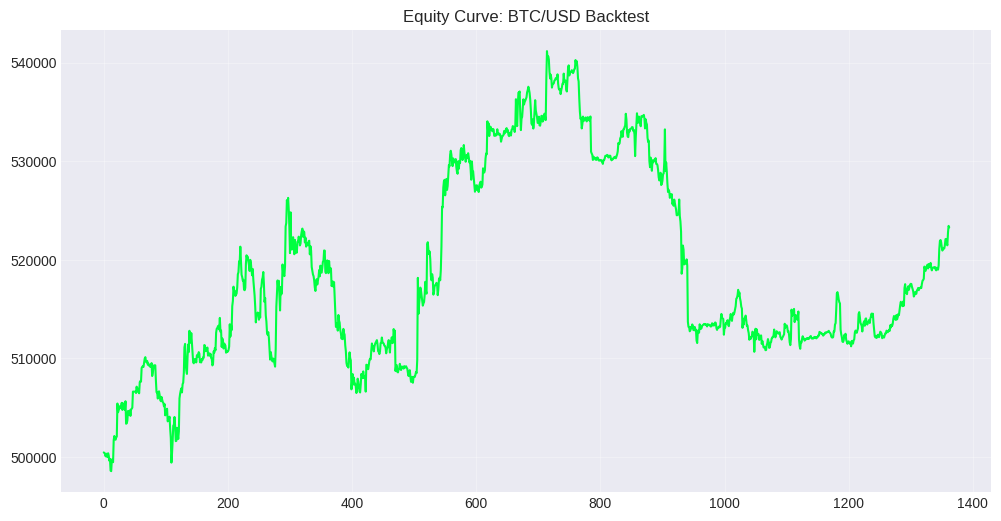

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

class ProfessionalTradingEngine:
    def __init__(self, initial_capital=500000, risk_per_trade=0.10, max_cap_per_trade=0.30):
        # Configuration
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.max_cap_per_trade = max_cap_per_trade
        self.fee_pct = 0.001  # 0.1% Total Friction

        # State
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

    def calculate_indicators(self, df):
        """Vectorized indicator calculation"""
        close = df['Close']
        high = df['High']
        low = df['Low']

        # McGinley Dynamic
        df['MD'] = self._mcginley_dynamic(close)

        # RSI
        delta = close.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        df['RSI'] = 100 - (100 / (1 + (gain / loss)))

        # MACD
        exp1 = close.ewm(span=12, adjust=False).mean()
        exp2 = close.ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

        # ATR
        tr = pd.concat([high - low,
                        abs(high - close.shift()),
                        abs(low - close.shift())], axis=1).max(axis=1)
        df['ATR'] = tr.rolling(window=14).mean()

        return df.fillna(method='bfill')

    def _mcginley_dynamic(self, prices, period=14, constant=0.6):
        md = [prices.iloc[0]]
        for i in range(1, len(prices)):
            p = prices.iloc[i]
            prev_md = md[-1]
            n = period * (p / prev_md)**4 * constant
            md.append(prev_md + (p - prev_md) / max(n, 1))
        return md

    def get_signals(self, df, i):
        prev_close = df['Close'].iloc[i-1]
        prev_md = df['MD'].iloc[i-1]
        prev_rsi = df['RSI'].iloc[i-1]
        prev_macd_h = df['MACD_Hist'].iloc[i-1]

        if prev_close > prev_md and prev_rsi > 45 and prev_macd_h > 0:
            return 'LONG'
        if prev_close < prev_md and prev_rsi < 55 and prev_macd_h < 0:
            return 'SHORT'
        return None

    def run_backtest(self, data):
        df = self.calculate_indicators(data.copy())

        for i in range(50, len(df)):
            current_bar = df.iloc[i]

            if self.position:
                self._manage_exit(df, i)

            if not self.position:
                signal = self.get_signals(df, i)
                if signal:
                    self._execute_entry(df, i, signal)

            # Record unrealized equity
            equity = self.capital
            if self.position:
                qty = self.position['qty']
                diff = (current_bar['Close'] - self.position['entry_price']) if self.position['type'] == 'LONG' else (self.position['entry_price'] - current_bar['Close'])
                equity += qty * diff
            self.equity_curve.append(equity)

        return self._generate_report()

    def _execute_entry(self, df, i, side):
        entry_price = df['Open'].iloc[i]
        atr = df['ATR'].iloc[i-1]
        stop_dist = atr * 2
        if stop_dist == 0: return

        risk_amt = self.capital * self.risk_per_trade
        qty_based_on_risk = risk_amt / stop_dist
        max_allowed_qty = (self.capital * self.max_cap_per_trade) / entry_price
        final_qty = min(qty_based_on_risk, max_allowed_qty)

        self.capital -= (final_qty * entry_price) * self.fee_pct

        self.position = {
            'type': side,
            'qty': final_qty,
            'entry_price': entry_price,
            'entry_time': df.index[i],
            'entry_idx': i,
            'sl': entry_price - stop_dist if side == 'LONG' else entry_price + stop_dist,
            'tp': entry_price + (stop_dist * 2) if side == 'LONG' else entry_price - (stop_dist * 2)
        }

    def _manage_exit(self, df, i):
        bar = df.iloc[i]
        p = self.position
        exit_price = None
        reason = ""

        if p['type'] == 'LONG':
            if bar['Low'] <= p['sl']: exit_price, reason = p['sl'], "Stop Loss"
            elif bar['High'] >= p['tp']: exit_price, reason = p['tp'], "Take Profit"
        else:
            if bar['High'] >= p['sl']: exit_price, reason = p['sl'], "Stop Loss"
            elif bar['Low'] <= p['tp']: exit_price, reason = p['tp'], "Take Profit"

        if exit_price:
            fee = (p['qty'] * exit_price) * self.fee_pct
            pnl = ((exit_price - p['entry_price']) if p['type'] == 'LONG' else (p['entry_price'] - exit_price)) * p['qty']

            self.capital += pnl - fee
            self.trades.append({
                'entry_time': p['entry_time'],
                'exit_time': df.index[i],
                'type': p['type'],
                'pnl': pnl - fee,
                'pnl_pct': ((pnl - fee) / (p['qty'] * p['entry_price'])) * 100,
                'reason': reason,
                'bars_held': i - p['entry_idx']
            })
            self.position = None

    def _generate_report(self):
        if not self.trades: return None
        tdf = pd.DataFrame(self.trades)
        equity_series = pd.Series(self.equity_curve)

        # Calculate Max Drawdown
        roll_max = equity_series.cummax()
        drawdown = (equity_series - roll_max) / roll_max
        max_dd = drawdown.min() * 100

        # Calculate Sharpe Ratio (Daily approx from 1h)
        returns = equity_series.pct_change().dropna()
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252 * 24) if returns.std() != 0 else 0

        # Win streaks
        tdf['is_win'] = tdf['pnl'] > 0
        streak = tdf['is_win'].ne(tdf['is_win'].shift()).cumsum()
        streaks = tdf.groupby(streak)['is_win'].agg(['all', 'count'])
        max_win_streak = streaks[streaks['all']]['count'].max() if not streaks[streaks['all']].empty else 0
        max_loss_streak = streaks[~streaks['all']]['count'].max() if not streaks[~streaks['all']].empty else 0

        # Stats Dict
        stats = {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': ((self.capital - self.initial_capital) / self.initial_capital) * 100,
            'max_drawdown': abs(max_dd),
            'sharpe_ratio': sharpe,
            'total_trades': len(tdf),
            'total_long': len(tdf[tdf['type'] == 'LONG']),
            'total_short': len(tdf[tdf['type'] == 'SHORT']),
            'winning_trades': len(tdf[tdf['pnl'] > 0]),
            'losing_trades': len(tdf[tdf['pnl'] <= 0]),
            'win_rate': (tdf['pnl'] > 0).sum() / len(tdf) * 100,
            'avg_bars_held': tdf['bars_held'].mean(),
            'avg_win': tdf[tdf['pnl'] > 0]['pnl'].mean() if any(tdf['pnl'] > 0) else 0,
            'avg_loss': abs(tdf[tdf['pnl'] <= 0]['pnl'].mean()) if any(tdf['pnl'] <= 0) else 0,
            'max_win_streak': max_win_streak,
            'max_loss_streak': max_loss_streak,
            'trades_df': tdf
        }

        # Profit Factor
        gross_profit = tdf[tdf['pnl'] > 0]['pnl'].sum()
        gross_loss = abs(tdf[tdf['pnl'] <= 0]['pnl'].sum())
        stats['profit_factor'] = gross_profit / gross_loss if gross_loss != 0 else 0

        return stats

    def print_results(self, results):
        """Print formatted results"""
        if not results:
            print("No trades executed.")
            return

        print(f"{'='*80}")
        print("📈 BACKTEST RESULTS")
        print(f"{'='*80}\n")

        print("💰 CAPITAL PERFORMANCE")
        print(f"  Initial Capital:     ₹{results['initial_capital']:>12,.0f}")
        print(f"  Final Capital:       ₹{results['final_capital']:>12,.0f}")
        print(f"  Total Return:        {results['total_return']:>12.2f}%")
        print(f"  Max Drawdown:        {results['max_drawdown']:>12.2f}%")
        print(f"  Sharpe Ratio:        {results['sharpe_ratio']:>12.2f}")

        print(f"\n📊 TRADE STATISTICS")
        print(f"  Total Trades:        {results['total_trades']:>12}")
        print(f"  Long Trades:         {results['total_long']:>12}")
        print(f"  Short Trades:        {results['total_short']:>12}")
        print(f"  Winning Trades:      {results['winning_trades']:>12}")
        print(f"  Losing Trades:       {results['losing_trades']:>12}")
        print(f"  Win Rate:            {results['win_rate']:>12.1f}%")
        print(f"  Avg Bars Held:       {results['avg_bars_held']:>12.1f}")

        print(f"\n💵 PROFITABILITY")
        print(f"  Average Win:         ₹{results['avg_win']:>12,.0f}")
        print(f"  Average Loss:        ₹{results['avg_loss']:>12,.0f}")
        print(f"  Profit Factor:       {results['profit_factor']:>12.2f}")
        print(f"  Max Win Streak:      {results['max_win_streak']:>12}")
        print(f"  Max Loss Streak:     {results['max_loss_streak']:>12}")

        print(f"\n{'='*80}")
        print("📋 LAST 10 TRADES")
        print(f"{'='*80}")
        if not results['trades_df'].empty:
            last_10 = results['trades_df'].tail(10)
            for _, row in last_10.iterrows():
                icon = "🟢" if row['pnl'] > 0 else "🔴"
                print(f" {icon} {row['exit_time']} | {row['type']:5} | PnL: ₹{row['pnl']:>8.0f} ({row['pnl_pct']:>6.2f}%) | {row['reason']}")
        print(f"{'='*80}\n")

# --- Execution ---

def download_mexc_style_data(ticker="BTC-USD"):
    data = yf.download(ticker, period="60d", interval="1h", progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

if __name__ == "__main__":
    df = download_mexc_style_data("BTC-USD")

    engine = ProfessionalTradingEngine(
        initial_capital=500000,
        risk_per_trade=0.10,
        max_cap_per_trade=0.30
    )

    backtest_stats = engine.run_backtest(df)
    engine.print_results(backtest_stats)

    if engine.equity_curve:
        plt.figure(figsize=(12, 6))
        plt.plot(engine.equity_curve, label='Equity Curve', color='#00ff41')
        plt.title('Equity Curve: BTC/USD Backtest')
        plt.grid(alpha=0.3)
        plt.show()

MEXC PRO TRADING ENGINE
Select Mode: 1 for Backtest, 2 for Live: 1
Ticker (default BTC-USD): 

⏳ Running Historical Backtest...

📈 COMPREHENSIVE BACKTEST RESULTS

💰 PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
  Initial Capital:         ₹     500,000.00
  Final Capital:           ₹     522,586.42
  Net P&L:                 +₹     22,586.42
  Total Return:                       4.52%
  Max Drawdown:                       5.64%
  Sharpe Ratio:                       1.64

📊 TRADE STATISTICS
--------------------------------------------------------------------------------
  Total Trades:                         69
  Long Trades:                          35
  Short Trades:                         34
  Winning Trades:                       31
  Losing Trades:                        38
  Win Rate:                         44.93%
  Average Bars Held:                  19.4

💵 PROFITABILITY METRICS
--------------------------------------------

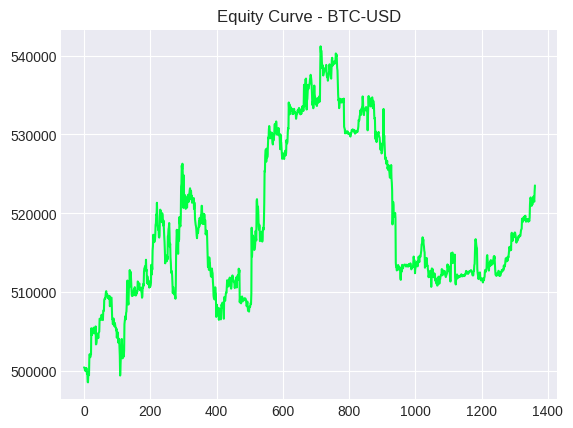

In [22]:
import requests
import time
import hmac
import hashlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# --- MEXC API CONFIGURATION ---
MEXC_BASE_URL = "https://api.mexc.com"

class ProfessionalTradingEngine:
    def __init__(self, initial_capital=500000, risk_per_trade=0.07, max_cap_per_trade=0.30, api_key=None, api_secret=None):
        self.initial_capital = initial_capital
        self.risk_per_trade = risk_per_trade
        self.max_cap_per_trade = max_cap_per_trade
        self.fee_pct = 0.001
        self.api_key = api_key
        self.api_secret = api_secret

        # State
        self.capital = initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = []

    # --- CORE INDICATORS ---
    def calculate_indicators(self, df):
        close, high, low = df['Close'], df['High'], df['Low']
        df['MD'] = self._mcginley_dynamic(close)

        delta = close.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        df['RSI'] = 100 - (100 / (1 + (gain / loss)))

        exp1, exp2 = close.ewm(span=12).mean(), close.ewm(span=26).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

        tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
        df['ATR'] = tr.rolling(14).mean()
        return df.fillna(method='bfill')

    def _mcginley_dynamic(self, prices, period=14, constant=0.6):
        md = [prices.iloc[0]]
        for i in range(1, len(prices)):
            p, prev_md = prices.iloc[i], md[-1]
            n = period * (p / prev_md)**4 * constant
            md.append(prev_md + (p - prev_md) / max(n, 1))
        return md

    def get_signal(self, df):
        last = df.iloc[-1]
        if last['Close'] > last['MD'] and last['RSI'] > 45 and last['MACD_Hist'] > 0:
            return 'LONG'
        if last['Close'] < last['MD'] and last['RSI'] < 55 and last['MACD_Hist'] < 0:
            return 'SHORT'
        return None

    # --- MODE 1: BACKTEST ---
    def run_backtest(self, data):
        print("\n⏳ Running Historical Backtest...")
        df = self.calculate_indicators(data.copy())
        for i in range(50, len(df)):
            if self.position:
                self._manage_backtest_exit(df, i)
            if not self.position:
                sig = self.get_signal(df.iloc[:i])
                if sig: self._execute_backtest_entry(df, i, sig)

            # Equity Tracking
            curr_equity = self.capital
            if self.position:
                p = self.position
                diff = (df['Close'].iloc[i] - p['entry_price']) if p['type'] == 'LONG' else (p['entry_price'] - df['Close'].iloc[i])
                curr_equity += p['qty'] * diff
            self.equity_curve.append(curr_equity)
        return self._generate_report()

    def _execute_backtest_entry(self, df, i, side):
        entry_p, atr = df['Open'].iloc[i], df['ATR'].iloc[i-1]
        stop_dist = atr * 2
        qty = min((self.capital * self.risk_per_trade) / stop_dist, (self.capital * self.max_cap_per_trade) / entry_p)
        self.capital -= (qty * entry_p) * self.fee_pct
        self.position = {'type': side, 'qty': qty, 'entry_price': entry_p, 'entry_time': df.index[i], 'entry_idx': i,
                         'sl': entry_p - stop_dist if side == 'LONG' else entry_p + stop_dist,
                         'tp': entry_p + (stop_dist * 2) if side == 'LONG' else entry_p - (stop_dist * 2)}

    def _manage_backtest_exit(self, df, i):
        bar, p = df.iloc[i], self.position
        exit_p = None
        if p['type'] == 'LONG':
            if bar['Low'] <= p['sl']: exit_p, reason = p['sl'], "Stop Loss"
            elif bar['High'] >= p['tp']: exit_p, reason = p['tp'], "Take Profit"
        else:
            if bar['High'] >= p['sl']: exit_p, reason = p['sl'], "Stop Loss"
            elif bar['Low'] <= p['tp']: exit_p, reason = p['tp'], "Take Profit"

        if exit_p:
            pnl = ((exit_p - p['entry_price']) if p['type'] == 'LONG' else (p['entry_price'] - exit_p)) * p['qty']
            self.capital += pnl - (p['qty'] * exit_p * self.fee_pct)
            self.trades.append({
                'entry_time': p['entry_time'],
                'exit_time': df.index[i],
                'type': p['type'],
                'entry_price': p['entry_price'],
                'exit_price': exit_p,
                'pnl': pnl - (p['qty'] * exit_p * self.fee_pct),
                'pnl_pct': (pnl/(p['qty']*p['entry_price']))*100,
                'reason': reason,
                'bars_held': i - p['entry_idx']
            })
            self.position = None

    # --- REPORT GENERATION ---
    def _generate_report(self):
        if not self.trades: return None
        tdf = pd.DataFrame(self.trades)
        equity_series = pd.Series(self.equity_curve)

        # Drawdown
        roll_max = equity_series.cummax()
        drawdown = (equity_series - roll_max) / roll_max
        max_dd = abs(drawdown.min() * 100)

        # Sharpe
        returns = equity_series.pct_change().dropna()
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252 * 24) if returns.std() != 0 else 0

        # Streaks
        tdf['is_win'] = tdf['pnl'] > 0
        streak = tdf['is_win'].ne(tdf['is_win'].shift()).cumsum()
        streaks = tdf.groupby(streak)['is_win'].agg(['all', 'count'])
        max_win_streak = streaks[streaks['all']]['count'].max() if any(streaks['all']) else 0
        max_loss_streak = streaks[~streaks['all']]['count'].max() if any(~streaks['all']) else 0

        stats = {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': ((self.capital - self.initial_capital) / self.initial_capital) * 100,
            'max_drawdown': max_dd,
            'sharpe_ratio': sharpe,
            'total_trades': len(tdf),
            'total_long': len(tdf[tdf['type'] == 'LONG']),
            'total_short': len(tdf[tdf['type'] == 'SHORT']),
            'winning_trades': len(tdf[tdf['pnl'] > 0]),
            'losing_trades': len(tdf[tdf['pnl'] <= 0]),
            'win_rate': (tdf['pnl'] > 0).mean() * 100,
            'avg_bars_held': tdf['bars_held'].mean(),
            'avg_win': tdf[tdf['pnl'] > 0]['pnl'].mean() if any(tdf['pnl'] > 0) else 0,
            'avg_loss': abs(tdf[tdf['pnl'] <= 0]['pnl'].mean()) if any(tdf['pnl'] <= 0) else 0,
            'max_win_streak': max_win_streak,
            'max_loss_streak': max_loss_streak,
            'profit_factor': (tdf[tdf['pnl'] > 0]['pnl'].sum() / abs(tdf[tdf['pnl'] <= 0]['pnl'].sum())) if any(tdf['pnl'] <= 0) else 0,
            'trades_df': tdf
        }
        return stats

    def print_detailed_results(self, results):
        """Print detailed backtest results"""
        if not results:
            print("No trades executed.")
            return

        print("\n" + "="*80)
        print("📈 COMPREHENSIVE BACKTEST RESULTS")
        print("="*80 + "\n")

        print("💰 PERFORMANCE SUMMARY")
        print("-" * 80)
        print(f"  Initial Capital:         ₹{results['initial_capital']:>15,.2f}")
        print(f"  Final Capital:           ₹{results['final_capital']:>15,.2f}")
        pnl = results['final_capital'] - results['initial_capital']
        pnl_color = "+" if pnl >= 0 else ""
        print(f"  Net P&L:                 {pnl_color}₹{pnl:>14,.2f}")
        print(f"  Total Return:            {results['total_return']:>15.2f}%")
        print(f"  Max Drawdown:            {results['max_drawdown']:>15.2f}%")
        print(f"  Sharpe Ratio:            {results['sharpe_ratio']:>15.2f}")

        print(f"\n📊 TRADE STATISTICS")
        print("-" * 80)
        print(f"  Total Trades:            {results['total_trades']:>15}")
        print(f"  Long Trades:             {results['total_long']:>15}")
        print(f"  Short Trades:            {results['total_short']:>15}")
        print(f"  Winning Trades:          {results['winning_trades']:>15}")
        print(f"  Losing Trades:           {results['losing_trades']:>15}")
        print(f"  Win Rate:                {results['win_rate']:>14.2f}%")
        print(f"  Average Bars Held:       {results.get('avg_bars_held', 0):>15.1f}")

        print(f"\n💵 PROFITABILITY METRICS")
        print("-" * 80)
        print(f"  Average Win:             ₹{results['avg_win']:>15,.2f}")
        print(f"  Average Loss:            ₹{results['avg_loss']:>15,.2f}")
        ratio = results['avg_win'] / results['avg_loss'] if results['avg_loss'] > 0 else 0
        status = "✅ TARGET MET" if ratio >= 1.5 else "❌ NEEDS IMPROVEMENT"
        print(f"  Win/Loss Ratio:          {ratio:>15.2f}x {status}")
        print(f"  Profit Factor:           {results['profit_factor']:>15.2f}")
        print(f"  Max Win Streak:          {results.get('max_win_streak', 0):>15}")
        print(f"  Max Loss Streak:         {results.get('max_loss_streak', 0):>15}")

        print(f"\n{'='*80}")
        print("📋 RECENT TRADES (Last 10)")
        print("="*80)
        print(f"{'Type':<7} {'Entry':>10} {'Exit':>10} {'P&L%':>8} {'P&L':>12} {'Reason':<20}")
        print("-" * 80)

        tdf = results['trades_df'].tail(10)
        for _, row in tdf.iterrows():
            print(f"{row['type']:<7} {row['entry_price']:>10.2f} {row['exit_price']:>10.2f} {row['pnl_pct']:>7.2f}% ₹{row['pnl']:>11.0f} {row['reason']:<20}")
        print("-" * 80 + "\n")

    # --- MODE 2: LIVE TRADING (MEXC) ---
    def run_live(self, symbol="BTCUSDT"):
        print(f"\n🚀 Live Mode Activated for {symbol}...")
        while True:
            try:
                df = self._fetch_mexc_klines(symbol)
                df = self.calculate_indicators(df)
                signal = self.get_signal(df)
                curr_price = df['Close'].iloc[-1]
                print(f"[{datetime.now().strftime('%H:%M:%S')}] Price: {curr_price:.2f} | RSI: {df['RSI'].iloc[-1]:.1f} | Signal: {signal}")
                time.sleep(60)
            except Exception as e:
                print(f"⚠️ Error: {e}")
                time.sleep(10)

    def _fetch_mexc_klines(self, symbol):
        url = f"{MEXC_BASE_URL}/api/v3/klines?symbol={symbol}&interval=1h&limit=100"
        resp = requests.get(url).json()
        data = pd.DataFrame(resp, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Vol', 'CloseTime', 'QVol'])
        data['Time'] = pd.to_datetime(data['Time'], unit='ms')
        for col in ['Open', 'High', 'Low', 'Close']: data[col] = data[col].astype(float)
        return data.set_index('Time')

# --- EXECUTION ---
if __name__ == "__main__":
    print("MEXC PRO TRADING ENGINE")
    choice = input("Select Mode: 1 for Backtest, 2 for Live: ")
    engine = ProfessionalTradingEngine(initial_capital=500000)

    if choice == '1':
        ticker = input("Ticker (default BTC-USD): ") or "BTC-USD"
        data = yf.download(ticker, period="60d", interval="1h", progress=False)
        if isinstance(data.columns, pd.MultiIndex): data.columns = data.columns.get_level_values(0)

        stats = engine.run_backtest(data)
        engine.print_detailed_results(stats)

        if engine.equity_curve:
            plt.plot(engine.equity_curve, color='#00ff41')
            plt.title(f"Equity Curve - {ticker}")
            plt.show()
    else:
        engine.run_live("BTCUSDT")